# AC-GAN on CIFAR-10

# Setup imports and hyperparameters

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
from itertools import cycle
from tqdm import tqdm  # for displaying progress bar

In [ ]:
# Install extra package if FID is needed
!pip install pytorch-fid
from pytorch_fid import fid_score

In [3]:
# Hyperparameters from Table 2 in "Conditional Image Synthesis with Auxiliary Classifier GANs"
z_dim = 100  # Size of the noise vector
num_classes = 10  # Number of classes for CIFAR-10
lr = [0.0001, 0.0002, 0.0003]  # Learning rate for Adam optimizer
betas = (0.5, 0.999)  # Betas for Adam optimizer
batch_size = 100
image_size = 32
channels_img = 3
gen_features = 384  # Feature maps for the first layer of generator
disc_features = 16  # Feature maps for the first layer of discriminator
num_epochs = 200  # Assuming 50 for a shorter training time; can be changed to 50000 iterations
leaky_slope = 0.2  # Slope for the leaky ReLU
drop_out = 0.5  # Dropout rate
sigma_noise = 0.05  # Standard deviation for Gaussian noise

# Define two DNNs

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, num_classes, img_channels):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)

        # Define individual layers to access their output for printing
        self.init_linear = nn.Linear(z_dim + num_classes, 384 * 4 * 4, bias=False)
        self.init_relu = nn.ReLU(True)

        self.conv_transpose1 = nn.ConvTranspose2d(384, 192, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(192)
        self.relu1 = nn.ReLU(True)

        self.conv_transpose2 = nn.ConvTranspose2d(192, 96, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(96)
        self.relu2 = nn.ReLU(True)

        self.conv_transpose3 = nn.ConvTranspose2d(96, img_channels, kernel_size=5, stride=2, padding=2, output_padding=1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, noise, labels):
        # Concatenate label embedding with noise
        labels = self.label_emb(labels)
        gen_input = torch.cat((noise, labels), -1)

        # Pass through initial linear layer and activation
        out = self.init_linear(gen_input)
        out = self.init_relu(out)
        out = out.view(out.size(0), 384, 4, 4)  # Reshape to (batch_size, 384, 4, 4)
        # print("After initial linear layer:", out.shape)

        # Pass through first transposed convolution layer
        out = self.conv_transpose1(out)
        out = self.bn1(out)
        out = self.relu1(out)
        # print("After first ConvTranspose2d:", out.shape)

        # Pass through second transposed convolution layer
        out = self.conv_transpose2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        # print("After second ConvTranspose2d:", out.shape)

        # Pass through third transposed convolution layer
        out = self.conv_transpose3(out)
        out = self.tanh(out)
        # print("After third ConvTranspose2d:", out.shape)

        return out

In [5]:
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float): Standard deviation of the Gaussian noise.
    """
    def __init__(self, sigma=0.05):
        super(GaussianNoise, self).__init__()
        self.sigma = sigma

    def forward(self, x):
        if self.training:
            noise = torch.randn_like(x) * self.sigma
            return x + noise
        return x

class Discriminator(nn.Module):
    def __init__(self, gaussian_noise, img_channels, num_classes):
        super(Discriminator, self).__init__()
        self.noise = GaussianNoise(gaussian_noise)

        # Discriminator's Convolutional Layers with kernel size and stride as arguments
        self.main = nn.Sequential(
            # Input is 32 x 32 x img_channels
            nn.Conv2d(img_channels, 16, kernel_size=3, stride=2, padding=1, bias=False),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),    # State size: 16 x 16 x 16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),    # State size: 32 x 16 x 16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=False),   # State size: 64 x 8 x 8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),  # State size: 128 x 8 x 8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=False),  # State size: 256 x 4 x 4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(drop_out),

            nn.Flatten()
        )

        # Output head for real/fake classification
        self.adv_layer = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1),
            nn.Sigmoid()
        )

        # Output head for class prediction
        self.class_layer = nn.Linear(512 * 4 * 4, num_classes)

    def forward(self, img):
        img = self.noise(img)
        # Pass the input image through the feature extractor
        features = self.main(img)

        # Pass the features through the two heads
        real_fake = self.adv_layer(features)
        classes = self.class_layer(features)

        return real_fake, classes

# Initialize models

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if 'Conv' in classname:
        torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
    elif 'BatchNorm' in classname:
        torch.nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
        torch.nn.init.constant_(m.bias.data, 0)
    elif "Linear" in classname:
        torch.nn.init.normal_(m.weight.data, mean=0.0, std=0.02)

In [6]:
# Transformations for the input data
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])

# Load the CIFAR-10 dataset
full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split CIFAR-10 into training and testing sets
train_size = int(0.9 * len(full_dataset))  # 90% for training
validation_size = len(full_dataset) - train_size  # 10% for validation
train_dataset, validation_dataset = random_split(full_dataset, [train_size, validation_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

# Initialize Generator and Discriminator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(z_dim, num_classes, channels_img).to(device)
discriminator = Discriminator(sigma_noise, channels_img, num_classes).to(device)

# Initialize weights
'''
generator.apply(weights_init)
discriminator.apply(weights_init)
'''

# Load pre-trained models
generator.load_state_dict(torch.load('/content/drive/MyDrive/ECE661/Project/AC-GAN/generator-2.pth'))
discriminator.load_state_dict(torch.load('/content/drive/MyDrive/ECE661/Project/AC-GAN/discriminator-3.pth'))

# Binary Cross Entropy loss and auxiliary classification loss
adversarial_loss = nn.BCELoss().to(device)
auxiliary_loss = nn.CrossEntropyLoss().to(device)

# Setup Adam optimizers for both G and D
optimizer_G = optim.Adam(generator.parameters(), lr=lr[1], betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr[1], betas=betas)

100%|██████████| 170498071/170498071 [00:03<00:00, 48400609.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


# Train AC-GAN

In [ ]:
# Record training process for later use
G_loss = []
D_loss = []
D_adv_loss = []
D_aux_loss = []
D_val_adv_loss = []
D_val_aux_loss = []
G_grad = []
D_grad = []
FID = []

In [ ]:
# Change learning rate manually
optimizer_G = optim.Adam(generator.parameters(), lr=lr[1], betas=betas)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr[1], betas=betas)

In [ ]:
# Initialize settings before start training
validation_iterator = cycle(validation_dataloader)
os.makedirs("generated_images", exist_ok=True)
os.makedirs("real_images", exist_ok=True)
real_images_path = "./real_images"
generated_images_path = "./generated_images"
real_imgs_save, labels = next(validation_iterator)
vutils.save_image(real_imgs_save[:min(batch_size, 100)], f"{real_images_path}/real_samples.png", normalize=True)
dynamic_lr = lr[1]

In [ ]:
# Training Loop
for epoch in range(num_epochs):
    # ------------------------------------------
    # Train the model
    # ------------------------------------------
    if epoch % 50 == 0 and epoch > 1:
        dynamic_lr = dynamic_lr * 0.7
        optimizer_G = optim.Adam(generator.parameters(), lr=dynamic_lr, betas=betas)
        optimizer_D = optim.Adam(discriminator.parameters(), lr=dynamic_lr, betas=betas)
        print(f"Learning rate changed to {dynamic_lr}")

    G_loss_sum = 0
    D_loss_sum = 0
    D_adv_loss_sum = 0
    D_aux_loss_sum = 0
    G_grad_sum = 0
    D_grad_sum = 0
    num = 0
    for i, (imgs, labels) in enumerate(tqdm(train_dataloader)):

        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        # Prepare labels for real and fake images
        real_validity = torch.ones(batch_size, 1, device=device)
        fake_validity = torch.zeros(batch_size, 1, device=device)

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise as generator input
        # z = torch.randn(batch_size, z_dim, device=device)
        z = torch.normal(0, 2, (batch_size, z_dim)).to(device)
        gen_labels = torch.randint(0, num_classes, (batch_size,), device=device).long()

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity, pred_labels = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, real_validity) + auxiliary_loss(pred_labels, gen_labels)
        G_loss_sum += g_loss.item()

        g_loss.backward()

        # Calculate gradients
        total_grad_norm_generator = 0
        num_params_generator = 0
        for param in generator.parameters():
            if param.grad is not None:
                total_grad_norm_generator += param.grad.data.norm(2).item()**2  # Sum of squares
                num_params_generator += param.grad.data.numel()  # Count the number of elements
        if num_params_generator > 0:
            avg_grad_norm_generator = (total_grad_norm_generator / num_params_generator)**0.5
        else:
            avg_grad_norm_generator = 0
        G_grad_sum += avg_grad_norm_generator

        optimizer_G.step()

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_pred, real_aux = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_pred, real_validity) + auxiliary_loss(real_aux, labels)

        fake_pred, fake_aux = discriminator(gen_imgs.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake_validity) + auxiliary_loss(fake_aux, gen_labels)

        d_adv_loss = adversarial_loss(real_pred, real_validity) + adversarial_loss(fake_pred, fake_validity)
        d_aux_loss = auxiliary_loss(real_aux, labels) + auxiliary_loss(fake_aux, gen_labels)
        D_adv_loss_sum += d_adv_loss.item()
        D_aux_loss_sum += d_aux_loss.item()

        # Total discriminator loss
        d_loss = d_real_loss + d_fake_loss
        D_loss_sum += d_loss.item()
        num += 1

        d_loss.backward()

        # Calculate gradients
        total_grad_norm_discriminator = 0
        num_params_discriminator = 0
        for param in discriminator.parameters():
            if param.grad is not None:
                total_grad_norm_discriminator += param.grad.data.norm(2).item()**2  # Sum of squares
                num_params_discriminator += param.grad.data.numel()  # Count the number of elements
        if num_params_discriminator > 0:
            avg_grad_norm_discriminator = (total_grad_norm_discriminator / num_params_discriminator)**0.5
        else:
            avg_grad_norm_discriminator = 0
        D_grad_sum += avg_grad_norm_discriminator

        optimizer_D.step()

    # Record the average value of loss function and gradients in 1 epoch
    G_loss.append(G_loss_sum / num)
    D_loss.append(D_loss_sum / num)
    D_adv_loss.append(D_adv_loss_sum / num)
    D_aux_loss.append(D_aux_loss_sum / num)
    G_grad.append(G_grad_sum / num)
    D_grad.append(D_grad_sum / num)

    # ------------------------------------------
    # Validate the model (discriminator only)
    # ------------------------------------------
    imgs, labels = next(validation_iterator)

    # Configure input
    real_imgs = imgs.to(device)
    labels = labels.to(device)

    # Prepare labels for real and fake images
    real_validity = torch.ones(batch_size, 1, device=device)

    # Measure discriminator's ability to classify real samples
    real_pred, real_aux = discriminator(real_imgs)
    d_val_adv_loss = adversarial_loss(real_pred, real_validity)
    d_val_aux_loss = auxiliary_loss(real_aux, labels)
    D_val_adv_loss.append(d_val_adv_loss.item())
    D_val_aux_loss.append(d_val_aux_loss.item())

    # Print the progress
    print(f"[Epoch {epoch}/{num_epochs}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")
    print(f"[D Adv loss: {d_adv_loss.item()}] [D Aux loss: {d_aux_loss.item()}]")
    print(f"[Validation D Adv loss: {d_val_adv_loss.item()}] [Validation D Aux loss: {d_val_aux_loss.item()}]")

    with torch.no_grad():
        # Generate a batch of images
        #sample_z = torch.randn(batch_size, z_dim, device=device)
        sample_z = torch.normal(0, 1.5, (batch_size, z_dim)).to(device)
        sample_labels = torch.randint(0, num_classes, (batch_size,), device=device).long()
        sample_images = generator(sample_z, sample_labels)
        vutils.save_image(sample_images[:min(batch_size, 100)], f"{generated_images_path}/epoch_{0}.png", normalize=True)

    # Compute FID score using saved images
    if epoch % 1 == 0:
        fid = fid_score.calculate_fid_given_paths([real_images_path, generated_images_path],
                                                  batch_size=100, device=device, dims=2048)
        FID.append(fid)
        print(f'FID score at Epoch {epoch}: {fid}')

# Save the models
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

100%|██████████| 450/450 [00:34<00:00, 12.99it/s]


[Epoch 0/200] [D loss: 4.862769603729248] [G loss: 2.0645804405212402]
[D Adv loss: 1.3536295890808105] [D Aux loss: 3.5091402530670166]
[Validation D Adv loss: 0.6919450163841248] [Validation D Aux loss: 2.267728328704834]


Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 288MB/s]


  0%|          | 0/1 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


100%|██████████| 1/1 [00:00<00:00, 10.79it/s]


FID score at Epoch 0: 434.3126802802449


100%|██████████| 450/450 [00:33<00:00, 13.30it/s]


[Epoch 1/200] [D loss: 4.457491874694824] [G loss: 1.2864248752593994]
[D Adv loss: 1.645769715309143] [D Aux loss: 2.8117222785949707]
[Validation D Adv loss: 0.6610559225082397] [Validation D Aux loss: 2.109783411026001]


100%|██████████| 1/1 [00:00<00:00, 10.19it/s]


100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


FID score at Epoch 1: 491.7953062940196


100%|██████████| 450/450 [00:32<00:00, 14.04it/s]


[Epoch 2/200] [D loss: 3.9336915016174316] [G loss: 1.154222846031189]
[D Adv loss: 1.3954031467437744] [D Aux loss: 2.5382883548736572]
[Validation D Adv loss: 0.7167571783065796] [Validation D Aux loss: 2.023789882659912]


100%|██████████| 1/1 [00:00<00:00,  8.06it/s]


100%|██████████| 1/1 [00:00<00:00,  6.51it/s]


FID score at Epoch 2: 371.74337099288516


100%|██████████| 450/450 [00:33<00:00, 13.53it/s]


[Epoch 3/200] [D loss: 3.4175734519958496] [G loss: 1.1983188390731812]
[D Adv loss: 1.1468522548675537] [D Aux loss: 2.270721197128296]
[Validation D Adv loss: 0.8350080847740173] [Validation D Aux loss: 2.1372430324554443]


100%|██████████| 1/1 [00:00<00:00, 10.04it/s]


100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


FID score at Epoch 3: 378.3415345684067


100%|██████████| 450/450 [00:37<00:00, 12.00it/s]


[Epoch 4/200] [D loss: 3.184818744659424] [G loss: 1.397505283355713]
[D Adv loss: 1.2090731859207153] [D Aux loss: 1.9757455587387085]
[Validation D Adv loss: 0.7892945408821106] [Validation D Aux loss: 1.7856934070587158]


100%|██████████| 1/1 [00:00<00:00,  9.82it/s]


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


FID score at Epoch 4: 365.17379727516294


100%|██████████| 450/450 [00:33<00:00, 13.57it/s]


[Epoch 5/200] [D loss: 3.2293872833251953] [G loss: 1.3340996503829956]
[D Adv loss: 1.138562560081482] [D Aux loss: 2.090824604034424]
[Validation D Adv loss: 0.5962875485420227] [Validation D Aux loss: 1.5299679040908813]


100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


FID score at Epoch 5: 320.86209457609334


100%|██████████| 450/450 [00:33<00:00, 13.41it/s]


[Epoch 6/200] [D loss: 2.702946424484253] [G loss: 1.1614809036254883]
[D Adv loss: 1.1742051839828491] [D Aux loss: 1.5287412405014038]
[Validation D Adv loss: 0.8363487124443054] [Validation D Aux loss: 1.6940028667449951]


100%|██████████| 1/1 [00:00<00:00,  9.95it/s]


100%|██████████| 1/1 [00:00<00:00,  9.81it/s]


FID score at Epoch 6: 398.5042374104748


100%|██████████| 450/450 [00:33<00:00, 13.30it/s]


[Epoch 7/200] [D loss: 2.8109755516052246] [G loss: 1.0371850728988647]
[D Adv loss: 1.0591353178024292] [D Aux loss: 1.7518401145935059]
[Validation D Adv loss: 0.7655673027038574] [Validation D Aux loss: 1.5393586158752441]


100%|██████████| 1/1 [00:00<00:00, 10.41it/s]


100%|██████████| 1/1 [00:00<00:00, 10.47it/s]


FID score at Epoch 7: 336.99156921414703


100%|██████████| 450/450 [00:33<00:00, 13.48it/s]


[Epoch 8/200] [D loss: 3.129249334335327] [G loss: 0.977117121219635]
[D Adv loss: 1.2475112676620483] [D Aux loss: 1.881738305091858]
[Validation D Adv loss: 0.681384801864624] [Validation D Aux loss: 1.814292550086975]


100%|██████████| 1/1 [00:00<00:00, 10.43it/s]


100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


FID score at Epoch 8: 308.29604946986893


100%|██████████| 450/450 [00:33<00:00, 13.54it/s]


[Epoch 9/200] [D loss: 2.9249391555786133] [G loss: 1.4419119358062744]
[D Adv loss: 1.1271096467971802] [D Aux loss: 1.797829270362854]
[Validation D Adv loss: 0.5665774941444397] [Validation D Aux loss: 1.6299333572387695]


100%|██████████| 1/1 [00:00<00:00,  6.35it/s]


100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


FID score at Epoch 9: 246.19305406775368


100%|██████████| 450/450 [00:33<00:00, 13.55it/s]


[Epoch 10/200] [D loss: 2.8089513778686523] [G loss: 1.3086985349655151]
[D Adv loss: 1.1527154445648193] [D Aux loss: 1.6562358140945435]
[Validation D Adv loss: 0.6300739049911499] [Validation D Aux loss: 1.482620120048523]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


100%|██████████| 1/1 [00:00<00:00, 10.01it/s]


FID score at Epoch 10: 208.49954951297613


100%|██████████| 450/450 [00:33<00:00, 13.36it/s]


[Epoch 11/200] [D loss: 3.1529603004455566] [G loss: 1.2748677730560303]
[D Adv loss: 1.3908419609069824] [D Aux loss: 1.7621183395385742]
[Validation D Adv loss: 0.7338911890983582] [Validation D Aux loss: 1.3714250326156616]


100%|██████████| 1/1 [00:00<00:00, 10.02it/s]


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


FID score at Epoch 11: 213.79752281143143


100%|██████████| 450/450 [00:33<00:00, 13.36it/s]


[Epoch 12/200] [D loss: 3.080350875854492] [G loss: 1.0987986326217651]
[D Adv loss: 1.4137804508209229] [D Aux loss: 1.6665703058242798]
[Validation D Adv loss: 0.6556327939033508] [Validation D Aux loss: 1.5777106285095215]


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


FID score at Epoch 12: 244.43358604779834


100%|██████████| 450/450 [00:33<00:00, 13.33it/s]


[Epoch 13/200] [D loss: 2.7178006172180176] [G loss: 0.9274694919586182]
[D Adv loss: 1.1740586757659912] [D Aux loss: 1.5437419414520264]
[Validation D Adv loss: 0.5014789700508118] [Validation D Aux loss: 1.5374913215637207]


100%|██████████| 1/1 [00:00<00:00, 10.16it/s]


100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


FID score at Epoch 13: 241.07180761141436


100%|██████████| 450/450 [00:33<00:00, 13.36it/s]


[Epoch 14/200] [D loss: 2.8596980571746826] [G loss: 0.9302104711532593]
[D Adv loss: 1.3662874698638916] [D Aux loss: 1.4934107065200806]
[Validation D Adv loss: 0.5402855277061462] [Validation D Aux loss: 1.4491989612579346]


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]


FID score at Epoch 14: 244.43003300698018


100%|██████████| 450/450 [00:33<00:00, 13.50it/s]


[Epoch 15/200] [D loss: 2.9093523025512695] [G loss: 1.12554132938385]
[D Adv loss: 1.185275673866272] [D Aux loss: 1.724076509475708]
[Validation D Adv loss: 0.5516382455825806] [Validation D Aux loss: 1.693739414215088]


100%|██████████| 1/1 [00:00<00:00, 10.52it/s]


100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


FID score at Epoch 15: 248.93204947188542


100%|██████████| 450/450 [00:32<00:00, 13.67it/s]


[Epoch 16/200] [D loss: 2.928342342376709] [G loss: 1.0753954648971558]
[D Adv loss: 1.459315299987793] [D Aux loss: 1.469027042388916]
[Validation D Adv loss: 0.7366287708282471] [Validation D Aux loss: 1.2447818517684937]


100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


100%|██████████| 1/1 [00:00<00:00, 10.36it/s]


FID score at Epoch 16: 225.07439947256955


100%|██████████| 450/450 [00:33<00:00, 13.58it/s]


[Epoch 17/200] [D loss: 3.070091485977173] [G loss: 1.2916598320007324]
[D Adv loss: 1.2726109027862549] [D Aux loss: 1.797480583190918]
[Validation D Adv loss: 0.7283310294151306] [Validation D Aux loss: 1.3151435852050781]


100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


100%|██████████| 1/1 [00:00<00:00, 10.11it/s]


FID score at Epoch 17: 203.2510597713753


100%|██████████| 450/450 [00:33<00:00, 13.52it/s]


[Epoch 18/200] [D loss: 2.7333827018737793] [G loss: 0.9556254148483276]
[D Adv loss: 1.3222370147705078] [D Aux loss: 1.411145567893982]
[Validation D Adv loss: 0.6492459177970886] [Validation D Aux loss: 1.4490721225738525]


100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


100%|██████████| 1/1 [00:00<00:00, 10.45it/s]


FID score at Epoch 18: 184.37396767281137


100%|██████████| 450/450 [00:33<00:00, 13.50it/s]


[Epoch 19/200] [D loss: 2.584345817565918] [G loss: 1.0580086708068848]
[D Adv loss: 1.0485786199569702] [D Aux loss: 1.5357670783996582]
[Validation D Adv loss: 0.47476136684417725] [Validation D Aux loss: 1.4734753370285034]


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


FID score at Epoch 19: 198.197441961636


100%|██████████| 450/450 [00:33<00:00, 13.56it/s]


[Epoch 20/200] [D loss: 2.835212469100952] [G loss: 0.9109755158424377]
[D Adv loss: 1.3856605291366577] [D Aux loss: 1.4495519399642944]
[Validation D Adv loss: 0.723257303237915] [Validation D Aux loss: 1.1633275747299194]


100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


FID score at Epoch 20: 204.45607326363495


100%|██████████| 450/450 [00:32<00:00, 13.68it/s]


[Epoch 21/200] [D loss: 2.39616060256958] [G loss: 0.8296880722045898]
[D Adv loss: 1.1635266542434692] [D Aux loss: 1.2326340675354004]
[Validation D Adv loss: 0.7671682834625244] [Validation D Aux loss: 1.4783915281295776]


100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


FID score at Epoch 21: 191.72621825130625


100%|██████████| 450/450 [00:33<00:00, 13.61it/s]


[Epoch 22/200] [D loss: 2.6745424270629883] [G loss: 0.9808757901191711]
[D Adv loss: 1.1931865215301514] [D Aux loss: 1.4813560247421265]
[Validation D Adv loss: 0.6287862658500671] [Validation D Aux loss: 1.1788185834884644]


100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


100%|██████████| 1/1 [00:00<00:00, 10.62it/s]


FID score at Epoch 22: 230.0898775589282


100%|██████████| 450/450 [00:33<00:00, 13.55it/s]


[Epoch 23/200] [D loss: 2.6810035705566406] [G loss: 1.1302434206008911]
[D Adv loss: 1.1648082733154297] [D Aux loss: 1.516195297241211]
[Validation D Adv loss: 0.7365244626998901] [Validation D Aux loss: 1.3500796556472778]


100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


100%|██████████| 1/1 [00:00<00:00, 10.37it/s]


FID score at Epoch 23: 221.9470483506579


100%|██████████| 450/450 [00:33<00:00, 13.45it/s]


[Epoch 24/200] [D loss: 2.6519808769226074] [G loss: 0.9693523645401001]
[D Adv loss: 1.3242905139923096] [D Aux loss: 1.3276902437210083]
[Validation D Adv loss: 0.48893699049949646] [Validation D Aux loss: 1.4848768711090088]


100%|██████████| 1/1 [00:00<00:00,  9.92it/s]


100%|██████████| 1/1 [00:00<00:00,  9.91it/s]


FID score at Epoch 24: 191.99938847605844


100%|██████████| 450/450 [00:33<00:00, 13.57it/s]


[Epoch 25/200] [D loss: 2.5216164588928223] [G loss: 0.9294167160987854]
[D Adv loss: 1.1847867965698242] [D Aux loss: 1.336829662322998]
[Validation D Adv loss: 0.6048562526702881] [Validation D Aux loss: 1.4474575519561768]


100%|██████████| 1/1 [00:00<00:00,  9.96it/s]


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


FID score at Epoch 25: 181.02363355810448


100%|██████████| 450/450 [00:33<00:00, 13.59it/s]


[Epoch 26/200] [D loss: 2.504786968231201] [G loss: 0.9238582849502563]
[D Adv loss: 1.2345479726791382] [D Aux loss: 1.2702391147613525]
[Validation D Adv loss: 0.6985099911689758] [Validation D Aux loss: 1.5980223417282104]


100%|██████████| 1/1 [00:00<00:00, 10.09it/s]


100%|██████████| 1/1 [00:00<00:00, 10.32it/s]


FID score at Epoch 26: 166.27183894496164


100%|██████████| 450/450 [00:33<00:00, 13.63it/s]


[Epoch 27/200] [D loss: 2.440225839614868] [G loss: 1.2373188734054565]
[D Adv loss: 1.1102094650268555] [D Aux loss: 1.3300164937973022]
[Validation D Adv loss: 0.642019510269165] [Validation D Aux loss: 1.4982823133468628]


100%|██████████| 1/1 [00:00<00:00,  6.37it/s]


100%|██████████| 1/1 [00:00<00:00,  6.98it/s]


FID score at Epoch 27: 177.31101062526477


100%|██████████| 450/450 [00:32<00:00, 13.70it/s]


[Epoch 28/200] [D loss: 2.7336485385894775] [G loss: 1.0514612197875977]
[D Adv loss: 1.1574355363845825] [D Aux loss: 1.576213002204895]
[Validation D Adv loss: 0.4814259707927704] [Validation D Aux loss: 1.4929766654968262]


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


100%|██████████| 1/1 [00:00<00:00, 10.26it/s]


FID score at Epoch 28: 194.10484388082455


100%|██████████| 450/450 [00:32<00:00, 13.66it/s]


[Epoch 29/200] [D loss: 2.4363768100738525] [G loss: 0.980161726474762]
[D Adv loss: 1.1951580047607422] [D Aux loss: 1.2412186861038208]
[Validation D Adv loss: 0.6729133725166321] [Validation D Aux loss: 1.3665940761566162]


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


FID score at Epoch 29: 173.4834654873035


100%|██████████| 450/450 [00:33<00:00, 13.33it/s]


[Epoch 30/200] [D loss: 2.425065517425537] [G loss: 1.2035768032073975]
[D Adv loss: 1.019443154335022] [D Aux loss: 1.4056224822998047]
[Validation D Adv loss: 0.7056052088737488] [Validation D Aux loss: 1.3067023754119873]


100%|██████████| 1/1 [00:00<00:00, 10.33it/s]


100%|██████████| 1/1 [00:00<00:00,  9.79it/s]


FID score at Epoch 30: 189.40336174551078


100%|██████████| 450/450 [00:33<00:00, 13.56it/s]


[Epoch 31/200] [D loss: 2.855719566345215] [G loss: 0.8355798125267029]
[D Adv loss: 1.3385131359100342] [D Aux loss: 1.5172061920166016]
[Validation D Adv loss: 0.6987157464027405] [Validation D Aux loss: 1.505303978919983]


100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


100%|██████████| 1/1 [00:00<00:00, 10.12it/s]


FID score at Epoch 31: 215.03275085885653


100%|██████████| 450/450 [00:32<00:00, 13.74it/s]


[Epoch 32/200] [D loss: 2.9770984649658203] [G loss: 1.2025809288024902]
[D Adv loss: 1.4316102266311646] [D Aux loss: 1.5454882383346558]
[Validation D Adv loss: 0.5375677347183228] [Validation D Aux loss: 1.4415371417999268]


100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


FID score at Epoch 32: 176.94803447872346


100%|██████████| 450/450 [00:32<00:00, 13.72it/s]


[Epoch 33/200] [D loss: 2.499901056289673] [G loss: 0.7961031794548035]
[D Adv loss: 1.1501121520996094] [D Aux loss: 1.3497889041900635]
[Validation D Adv loss: 0.7252143025398254] [Validation D Aux loss: 1.231848120689392]


100%|██████████| 1/1 [00:00<00:00, 10.10it/s]


100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


FID score at Epoch 33: 164.92759771912645


100%|██████████| 450/450 [00:33<00:00, 13.56it/s]


[Epoch 34/200] [D loss: 2.728473663330078] [G loss: 1.0141713619232178]
[D Adv loss: 1.3703985214233398] [D Aux loss: 1.3580751419067383]
[Validation D Adv loss: 0.5819865465164185] [Validation D Aux loss: 1.2766417264938354]


100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


FID score at Epoch 34: 188.71895093753992


100%|██████████| 450/450 [00:33<00:00, 13.62it/s]


[Epoch 35/200] [D loss: 2.2834718227386475] [G loss: 0.8732560276985168]
[D Adv loss: 1.356583833694458] [D Aux loss: 0.926888108253479]
[Validation D Adv loss: 0.6281589269638062] [Validation D Aux loss: 1.2447589635849]


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


100%|██████████| 1/1 [00:00<00:00,  9.82it/s]


FID score at Epoch 35: 141.3591747399512


100%|██████████| 450/450 [00:33<00:00, 13.59it/s]


[Epoch 36/200] [D loss: 2.584024667739868] [G loss: 0.7153002619743347]
[D Adv loss: 1.279289722442627] [D Aux loss: 1.3047349452972412]
[Validation D Adv loss: 0.6421252489089966] [Validation D Aux loss: 1.3556872606277466]


100%|██████████| 1/1 [00:00<00:00, 10.23it/s]


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


FID score at Epoch 36: 160.72483436806982


100%|██████████| 450/450 [00:32<00:00, 13.67it/s]


[Epoch 37/200] [D loss: 2.5087592601776123] [G loss: 1.0066403150558472]
[D Adv loss: 1.226203203201294] [D Aux loss: 1.2825559377670288]
[Validation D Adv loss: 0.5509385466575623] [Validation D Aux loss: 0.9003950357437134]


100%|██████████| 1/1 [00:00<00:00, 10.20it/s]


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


FID score at Epoch 37: 196.4074442219743


100%|██████████| 450/450 [00:33<00:00, 13.61it/s]


[Epoch 38/200] [D loss: 2.6362853050231934] [G loss: 0.9923020601272583]
[D Adv loss: 1.3967201709747314] [D Aux loss: 1.239565134048462]
[Validation D Adv loss: 0.6736658811569214] [Validation D Aux loss: 1.2728041410446167]


100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


FID score at Epoch 38: 183.3198680733961


100%|██████████| 450/450 [00:33<00:00, 13.49it/s]


[Epoch 39/200] [D loss: 2.8319852352142334] [G loss: 1.1517096757888794]
[D Adv loss: 1.3180961608886719] [D Aux loss: 1.5138890743255615]
[Validation D Adv loss: 0.623443603515625] [Validation D Aux loss: 1.1816505193710327]


100%|██████████| 1/1 [00:00<00:00,  9.89it/s]


100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


FID score at Epoch 39: 174.19217439354966


100%|██████████| 450/450 [00:33<00:00, 13.52it/s]


[Epoch 40/200] [D loss: 2.334533214569092] [G loss: 1.050563097000122]
[D Adv loss: 1.0868690013885498] [D Aux loss: 1.2476640939712524]
[Validation D Adv loss: 0.5612500309944153] [Validation D Aux loss: 1.318583369255066]


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


FID score at Epoch 40: 200.9554288391098


100%|██████████| 450/450 [00:33<00:00, 13.49it/s]


[Epoch 41/200] [D loss: 2.7420549392700195] [G loss: 0.7666611671447754]
[D Adv loss: 1.4257832765579224] [D Aux loss: 1.3162716627120972]
[Validation D Adv loss: 0.8324105739593506] [Validation D Aux loss: 1.1872515678405762]


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


FID score at Epoch 41: 170.90081428910125


100%|██████████| 450/450 [00:33<00:00, 13.45it/s]


[Epoch 42/200] [D loss: 2.6270294189453125] [G loss: 1.1103273630142212]
[D Adv loss: 1.2169853448867798] [D Aux loss: 1.4100440740585327]
[Validation D Adv loss: 0.728736400604248] [Validation D Aux loss: 1.1428790092468262]


100%|██████████| 1/1 [00:00<00:00,  9.91it/s]


100%|██████████| 1/1 [00:00<00:00,  9.72it/s]


FID score at Epoch 42: 157.4925837138545


100%|██████████| 450/450 [00:33<00:00, 13.58it/s]


[Epoch 43/200] [D loss: 2.4314050674438477] [G loss: 0.9386603832244873]
[D Adv loss: 1.379967451095581] [D Aux loss: 1.0514376163482666]
[Validation D Adv loss: 0.5784111022949219] [Validation D Aux loss: 1.347208857536316]


100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


FID score at Epoch 43: 164.66535482413371


100%|██████████| 450/450 [00:32<00:00, 13.67it/s]


[Epoch 44/200] [D loss: 2.39333176612854] [G loss: 1.0874204635620117]
[D Adv loss: 1.0814542770385742] [D Aux loss: 1.3118776082992554]
[Validation D Adv loss: 0.652472734451294] [Validation D Aux loss: 1.353171706199646]


100%|██████████| 1/1 [00:00<00:00,  9.88it/s]


100%|██████████| 1/1 [00:00<00:00,  9.26it/s]


FID score at Epoch 44: 184.1730836768744


100%|██████████| 450/450 [00:33<00:00, 13.61it/s]


[Epoch 45/200] [D loss: 2.453369140625] [G loss: 1.0066554546356201]
[D Adv loss: 1.2578070163726807] [D Aux loss: 1.1955622434616089]
[Validation D Adv loss: 0.8310174942016602] [Validation D Aux loss: 1.074803113937378]


100%|██████████| 1/1 [00:00<00:00, 10.15it/s]


100%|██████████| 1/1 [00:00<00:00,  9.81it/s]


FID score at Epoch 45: 154.6811658522876


100%|██████████| 450/450 [00:33<00:00, 13.53it/s]


[Epoch 46/200] [D loss: 2.9210588932037354] [G loss: 0.918316662311554]
[D Adv loss: 1.5063693523406982] [D Aux loss: 1.414689540863037]
[Validation D Adv loss: 0.6306427121162415] [Validation D Aux loss: 1.1605130434036255]


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


100%|██████████| 1/1 [00:00<00:00,  8.56it/s]


FID score at Epoch 46: 182.34731527118691


100%|██████████| 450/450 [00:33<00:00, 13.53it/s]


[Epoch 47/200] [D loss: 2.6813409328460693] [G loss: 0.8963907361030579]
[D Adv loss: 1.371899127960205] [D Aux loss: 1.3094416856765747]
[Validation D Adv loss: 0.6221698522567749] [Validation D Aux loss: 1.2990107536315918]


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


100%|██████████| 1/1 [00:00<00:00,  9.30it/s]


FID score at Epoch 47: 171.11091411420432


100%|██████████| 450/450 [00:33<00:00, 13.44it/s]


[Epoch 48/200] [D loss: 2.7304255962371826] [G loss: 1.055238962173462]
[D Adv loss: 1.3742504119873047] [D Aux loss: 1.3561753034591675]
[Validation D Adv loss: 0.5952610373497009] [Validation D Aux loss: 1.1067863702774048]


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


FID score at Epoch 48: 146.25321469200182


100%|██████████| 450/450 [00:32<00:00, 13.69it/s]


[Epoch 49/200] [D loss: 2.4712753295898438] [G loss: 0.9901316165924072]
[D Adv loss: 1.2653915882110596] [D Aux loss: 1.2058837413787842]
[Validation D Adv loss: 0.7346401810646057] [Validation D Aux loss: 1.087365746498108]


100%|██████████| 1/1 [00:00<00:00,  6.34it/s]


100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


FID score at Epoch 49: 173.9201224825812
Learning rate changed to 0.00014


100%|██████████| 450/450 [00:33<00:00, 13.59it/s]


[Epoch 50/200] [D loss: 2.435603618621826] [G loss: 0.8106725215911865]
[D Adv loss: 1.2255131006240845] [D Aux loss: 1.2100903987884521]
[Validation D Adv loss: 0.7162155508995056] [Validation D Aux loss: 1.255824327468872]


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


FID score at Epoch 50: 186.1236925590861


100%|██████████| 450/450 [00:33<00:00, 13.54it/s]


[Epoch 51/200] [D loss: 2.3478095531463623] [G loss: 1.0044031143188477]
[D Adv loss: 1.1775808334350586] [D Aux loss: 1.1702288389205933]
[Validation D Adv loss: 0.6409392952919006] [Validation D Aux loss: 1.3622488975524902]


100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


FID score at Epoch 51: 147.5482420863287


100%|██████████| 450/450 [00:33<00:00, 13.53it/s]


[Epoch 52/200] [D loss: 2.477987289428711] [G loss: 0.9186095595359802]
[D Adv loss: 1.331920862197876] [D Aux loss: 1.146066427230835]
[Validation D Adv loss: 0.9168527126312256] [Validation D Aux loss: 1.4602117538452148]


100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


100%|██████████| 1/1 [00:00<00:00,  9.41it/s]


FID score at Epoch 52: 157.49924246906247


100%|██████████| 450/450 [00:33<00:00, 13.52it/s]


[Epoch 53/200] [D loss: 2.2785120010375977] [G loss: 0.8758249878883362]
[D Adv loss: 1.307724118232727] [D Aux loss: 0.9707880616188049]
[Validation D Adv loss: 0.4886607527732849] [Validation D Aux loss: 1.4610050916671753]


100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


FID score at Epoch 53: 161.57146517563493


100%|██████████| 450/450 [00:33<00:00, 13.48it/s]


[Epoch 54/200] [D loss: 2.5280420780181885] [G loss: 0.820117712020874]
[D Adv loss: 1.352315068244934] [D Aux loss: 1.175727128982544]
[Validation D Adv loss: 0.7342665195465088] [Validation D Aux loss: 1.1045520305633545]


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


FID score at Epoch 54: 152.26154599208175


100%|██████████| 450/450 [00:32<00:00, 13.65it/s]


[Epoch 55/200] [D loss: 2.6611721515655518] [G loss: 0.9448621273040771]
[D Adv loss: 1.3459162712097168] [D Aux loss: 1.315255880355835]
[Validation D Adv loss: 0.5118729472160339] [Validation D Aux loss: 1.023911952972412]


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


FID score at Epoch 55: 159.82185426935007


100%|██████████| 450/450 [00:33<00:00, 13.42it/s]


[Epoch 56/200] [D loss: 2.4727942943573] [G loss: 0.981317400932312]
[D Adv loss: 1.215018630027771] [D Aux loss: 1.2577756643295288]
[Validation D Adv loss: 0.7479989528656006] [Validation D Aux loss: 1.1911957263946533]


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


FID score at Epoch 56: 168.574140152996


100%|██████████| 450/450 [00:33<00:00, 13.51it/s]


[Epoch 57/200] [D loss: 2.5401225090026855] [G loss: 0.8953896164894104]
[D Adv loss: 1.1710937023162842] [D Aux loss: 1.3690285682678223]
[Validation D Adv loss: 0.6099373698234558] [Validation D Aux loss: 1.0329854488372803]


100%|██████████| 1/1 [00:00<00:00,  9.85it/s]


100%|██████████| 1/1 [00:00<00:00,  9.80it/s]


FID score at Epoch 57: 159.03621718717133


100%|██████████| 450/450 [00:33<00:00, 13.49it/s]


[Epoch 58/200] [D loss: 2.633579730987549] [G loss: 1.0110622644424438]
[D Adv loss: 1.1874353885650635] [D Aux loss: 1.4461445808410645]
[Validation D Adv loss: 0.5737019777297974] [Validation D Aux loss: 1.2133933305740356]


100%|██████████| 1/1 [00:00<00:00,  9.99it/s]


100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


FID score at Epoch 58: 192.37842625545147


100%|██████████| 450/450 [00:33<00:00, 13.50it/s]


[Epoch 59/200] [D loss: 2.5860769748687744] [G loss: 0.9775047302246094]
[D Adv loss: 1.3377137184143066] [D Aux loss: 1.2483631372451782]
[Validation D Adv loss: 0.5918388366699219] [Validation D Aux loss: 1.0100845098495483]


100%|██████████| 1/1 [00:00<00:00,  9.86it/s]


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


FID score at Epoch 59: 132.7832135725087


100%|██████████| 450/450 [00:32<00:00, 13.66it/s]


[Epoch 60/200] [D loss: 2.6082475185394287] [G loss: 1.0309995412826538]
[D Adv loss: 1.2949447631835938] [D Aux loss: 1.313302755355835]
[Validation D Adv loss: 0.6648796200752258] [Validation D Aux loss: 1.008259654045105]


100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


100%|██████████| 1/1 [00:00<00:00,  9.40it/s]


FID score at Epoch 60: 203.08079055486675


100%|██████████| 450/450 [00:32<00:00, 13.70it/s]


[Epoch 61/200] [D loss: 2.293386459350586] [G loss: 0.935893714427948]
[D Adv loss: 0.9612106084823608] [D Aux loss: 1.332175850868225]
[Validation D Adv loss: 0.5871719717979431] [Validation D Aux loss: 1.1374092102050781]


100%|██████████| 1/1 [00:00<00:00, 10.08it/s]


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


FID score at Epoch 61: 182.88479370147692


100%|██████████| 450/450 [00:33<00:00, 13.53it/s]


[Epoch 62/200] [D loss: 2.84763765335083] [G loss: 1.0980323553085327]
[D Adv loss: 1.4654873609542847] [D Aux loss: 1.382150411605835]
[Validation D Adv loss: 0.6948983669281006] [Validation D Aux loss: 1.4383102655410767]


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


FID score at Epoch 62: 146.97217222595194


100%|██████████| 450/450 [00:33<00:00, 13.59it/s]


[Epoch 63/200] [D loss: 2.357705593109131] [G loss: 1.1944981813430786]
[D Adv loss: 1.389519214630127] [D Aux loss: 0.9681864976882935]
[Validation D Adv loss: 0.5633299946784973] [Validation D Aux loss: 1.2560620307922363]


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


FID score at Epoch 63: 163.5493469639506


100%|██████████| 450/450 [00:33<00:00, 13.54it/s]


[Epoch 64/200] [D loss: 2.5856454372406006] [G loss: 1.2053475379943848]
[D Adv loss: 1.436814785003662] [D Aux loss: 1.148830533027649]
[Validation D Adv loss: 0.7197385430335999] [Validation D Aux loss: 1.1117522716522217]


100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


100%|██████████| 1/1 [00:00<00:00,  9.74it/s]


FID score at Epoch 64: 159.06447426234575


100%|██████████| 450/450 [00:33<00:00, 13.60it/s]


[Epoch 65/200] [D loss: 2.2536003589630127] [G loss: 1.014581561088562]
[D Adv loss: 1.0331717729568481] [D Aux loss: 1.220428705215454]
[Validation D Adv loss: 0.7364448308944702] [Validation D Aux loss: 1.2983710765838623]


100%|██████████| 1/1 [00:00<00:00,  9.85it/s]


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


FID score at Epoch 65: 142.24250400498386


100%|██████████| 450/450 [00:33<00:00, 13.54it/s]


[Epoch 66/200] [D loss: 2.736114025115967] [G loss: 0.9076294898986816]
[D Adv loss: 1.3846533298492432] [D Aux loss: 1.3514606952667236]
[Validation D Adv loss: 0.5188127756118774] [Validation D Aux loss: 0.9241064190864563]


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


FID score at Epoch 66: 125.93852167036721


100%|██████████| 450/450 [00:33<00:00, 13.50it/s]


[Epoch 67/200] [D loss: 2.165571689605713] [G loss: 0.9536880850791931]
[D Adv loss: 1.0002353191375732] [D Aux loss: 1.1653364896774292]
[Validation D Adv loss: 0.7392240762710571] [Validation D Aux loss: 1.0688396692276]


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


FID score at Epoch 67: 145.23733463300695


100%|██████████| 450/450 [00:33<00:00, 13.51it/s]


[Epoch 68/200] [D loss: 2.2694902420043945] [G loss: 1.0119377374649048]
[D Adv loss: 1.2466545104980469] [D Aux loss: 1.0228357315063477]
[Validation D Adv loss: 0.6650975942611694] [Validation D Aux loss: 1.3672611713409424]


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


100%|██████████| 1/1 [00:00<00:00,  8.62it/s]


FID score at Epoch 68: 169.58692960861492


100%|██████████| 450/450 [00:33<00:00, 13.49it/s]


[Epoch 69/200] [D loss: 2.644080638885498] [G loss: 0.944115161895752]
[D Adv loss: 1.471629023551941] [D Aux loss: 1.1724514961242676]
[Validation D Adv loss: 0.7874023914337158] [Validation D Aux loss: 0.9650472402572632]


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


FID score at Epoch 69: 157.8946269165322


100%|██████████| 450/450 [00:33<00:00, 13.47it/s]


[Epoch 70/200] [D loss: 2.1975443363189697] [G loss: 1.004974126815796]
[D Adv loss: 1.1746455430984497] [D Aux loss: 1.0228989124298096]
[Validation D Adv loss: 0.8638021945953369] [Validation D Aux loss: 0.8148214817047119]


100%|██████████| 1/1 [00:00<00:00,  9.81it/s]


100%|██████████| 1/1 [00:00<00:00,  9.87it/s]


FID score at Epoch 70: 139.47475666403218


100%|██████████| 450/450 [00:33<00:00, 13.52it/s]


[Epoch 71/200] [D loss: 2.581444263458252] [G loss: 0.9642394185066223]
[D Adv loss: 1.4114482402801514] [D Aux loss: 1.1699961423873901]
[Validation D Adv loss: 0.6293066740036011] [Validation D Aux loss: 1.382133960723877]


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


100%|██████████| 1/1 [00:00<00:00,  9.25it/s]


FID score at Epoch 71: 132.9901482631543


100%|██████████| 450/450 [00:33<00:00, 13.63it/s]


[Epoch 72/200] [D loss: 2.2645511627197266] [G loss: 0.9932996034622192]
[D Adv loss: 1.2454400062561035] [D Aux loss: 1.0191113948822021]
[Validation D Adv loss: 0.6094497442245483] [Validation D Aux loss: 0.9747257828712463]


100%|██████████| 1/1 [00:00<00:00,  7.20it/s]


100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


FID score at Epoch 72: 163.27778980172454


100%|██████████| 450/450 [00:33<00:00, 13.53it/s]


[Epoch 73/200] [D loss: 2.754789352416992] [G loss: 1.0839687585830688]
[D Adv loss: 1.3199201822280884] [D Aux loss: 1.4348690509796143]
[Validation D Adv loss: 0.633068323135376] [Validation D Aux loss: 1.0266849994659424]


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


FID score at Epoch 73: 157.07738993561557


100%|██████████| 450/450 [00:36<00:00, 12.19it/s]


[Epoch 74/200] [D loss: 2.5112104415893555] [G loss: 0.9294097423553467]
[D Adv loss: 1.3743969202041626] [D Aux loss: 1.1368134021759033]
[Validation D Adv loss: 0.5649834871292114] [Validation D Aux loss: 1.3090282678604126]


100%|██████████| 1/1 [00:00<00:00,  9.50it/s]


100%|██████████| 1/1 [00:00<00:00,  9.88it/s]


FID score at Epoch 74: 170.53219327825144


100%|██████████| 450/450 [00:40<00:00, 11.19it/s]


[Epoch 75/200] [D loss: 2.7018914222717285] [G loss: 0.8831283450126648]
[D Adv loss: 1.4479858875274658] [D Aux loss: 1.2539055347442627]
[Validation D Adv loss: 0.5351094603538513] [Validation D Aux loss: 1.2180756330490112]


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


FID score at Epoch 75: 134.96372146030694


100%|██████████| 450/450 [00:35<00:00, 12.78it/s]


[Epoch 76/200] [D loss: 2.2710487842559814] [G loss: 0.8945978283882141]
[D Adv loss: 1.0740151405334473] [D Aux loss: 1.1970335245132446]
[Validation D Adv loss: 0.649932861328125] [Validation D Aux loss: 1.1259033679962158]


100%|██████████| 1/1 [00:00<00:00,  9.47it/s]


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


FID score at Epoch 76: 142.03007172213955


100%|██████████| 450/450 [00:44<00:00, 10.21it/s]


[Epoch 77/200] [D loss: 2.51477313041687] [G loss: 0.8024411797523499]
[D Adv loss: 1.1540480852127075] [D Aux loss: 1.3607250452041626]
[Validation D Adv loss: 0.5148608088493347] [Validation D Aux loss: 1.2727972269058228]


100%|██████████| 1/1 [00:00<00:00,  9.84it/s]


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


FID score at Epoch 77: 131.52133152990064


100%|██████████| 450/450 [00:34<00:00, 12.91it/s]


[Epoch 78/200] [D loss: 2.284393787384033] [G loss: 1.1438394784927368]
[D Adv loss: 1.3129794597625732] [D Aux loss: 0.97141432762146]
[Validation D Adv loss: 0.5628248453140259] [Validation D Aux loss: 1.2455101013183594]


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


FID score at Epoch 78: 138.0961758156829


100%|██████████| 450/450 [00:34<00:00, 12.96it/s]


[Epoch 79/200] [D loss: 2.317807912826538] [G loss: 1.2074239253997803]
[D Adv loss: 1.0906821489334106] [D Aux loss: 1.2271257638931274]
[Validation D Adv loss: 0.7357790470123291] [Validation D Aux loss: 1.1694549322128296]


100%|██████████| 1/1 [00:00<00:00,  9.87it/s]


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


FID score at Epoch 79: 156.9542945116977


100%|██████████| 450/450 [00:42<00:00, 10.48it/s]


[Epoch 80/200] [D loss: 2.260425567626953] [G loss: 1.1843663454055786]
[D Adv loss: 1.1288022994995117] [D Aux loss: 1.131623387336731]
[Validation D Adv loss: 0.5262895822525024] [Validation D Aux loss: 1.0185757875442505]


100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


FID score at Epoch 80: 158.21777579131216


100%|██████████| 450/450 [00:34<00:00, 13.23it/s]


[Epoch 81/200] [D loss: 2.2416696548461914] [G loss: 1.0815808773040771]
[D Adv loss: 1.272049903869629] [D Aux loss: 0.9696199297904968]
[Validation D Adv loss: 0.5664337873458862] [Validation D Aux loss: 1.3260140419006348]


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


FID score at Epoch 81: 143.7947988149352


100%|██████████| 450/450 [00:33<00:00, 13.57it/s]


[Epoch 82/200] [D loss: 2.807187557220459] [G loss: 1.0601669549942017]
[D Adv loss: 1.4579920768737793] [D Aux loss: 1.3491955995559692]
[Validation D Adv loss: 0.8629050254821777] [Validation D Aux loss: 1.1536904573440552]


100%|██████████| 1/1 [00:00<00:00,  6.24it/s]


100%|██████████| 1/1 [00:00<00:00,  8.20it/s]


FID score at Epoch 82: 176.82316197429435


100%|██████████| 450/450 [00:33<00:00, 13.30it/s]


[Epoch 83/200] [D loss: 2.072526454925537] [G loss: 1.0199148654937744]
[D Adv loss: 1.1737085580825806] [D Aux loss: 0.8988176584243774]
[Validation D Adv loss: 0.5514466762542725] [Validation D Aux loss: 1.1697826385498047]


100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


FID score at Epoch 83: 157.87398476165168


100%|██████████| 450/450 [00:33<00:00, 13.53it/s]


[Epoch 84/200] [D loss: 2.5502758026123047] [G loss: 1.0513019561767578]
[D Adv loss: 1.3251667022705078] [D Aux loss: 1.2251089811325073]
[Validation D Adv loss: 0.6455903649330139] [Validation D Aux loss: 0.9615645408630371]


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


FID score at Epoch 84: 161.162238973792


100%|██████████| 450/450 [00:33<00:00, 13.47it/s]


[Epoch 85/200] [D loss: 2.3927667140960693] [G loss: 0.9674286246299744]
[D Adv loss: 1.2905995845794678] [D Aux loss: 1.1021671295166016]
[Validation D Adv loss: 0.46831703186035156] [Validation D Aux loss: 1.0275510549545288]


100%|██████████| 1/1 [00:00<00:00,  9.27it/s]


100%|██████████| 1/1 [00:00<00:00,  8.71it/s]


FID score at Epoch 85: 136.6978310017748


100%|██████████| 450/450 [00:34<00:00, 13.09it/s]


[Epoch 86/200] [D loss: 2.408273696899414] [G loss: 0.915131688117981]
[D Adv loss: 1.1250414848327637] [D Aux loss: 1.28323233127594]
[Validation D Adv loss: 0.41676467657089233] [Validation D Aux loss: 1.2297468185424805]


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


100%|██████████| 1/1 [00:00<00:00,  9.62it/s]


FID score at Epoch 86: 127.5999616953089


100%|██████████| 450/450 [00:37<00:00, 11.88it/s]


[Epoch 87/200] [D loss: 2.4580793380737305] [G loss: 1.0407902002334595]
[D Adv loss: 1.2019898891448975] [D Aux loss: 1.256089448928833]
[Validation D Adv loss: 0.6340659856796265] [Validation D Aux loss: 0.9065102934837341]


100%|██████████| 1/1 [00:00<00:00,  9.93it/s]


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


FID score at Epoch 87: 129.36376270480505


100%|██████████| 450/450 [00:40<00:00, 11.23it/s]


[Epoch 88/200] [D loss: 2.6004481315612793] [G loss: 0.7957978844642639]
[D Adv loss: 1.3136792182922363] [D Aux loss: 1.286768913269043]
[Validation D Adv loss: 0.5814801454544067] [Validation D Aux loss: 1.1387090682983398]


100%|██████████| 1/1 [00:00<00:00,  6.18it/s]


100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


FID score at Epoch 88: 164.59806943533954


100%|██████████| 450/450 [00:33<00:00, 13.59it/s]


[Epoch 89/200] [D loss: 2.2487924098968506] [G loss: 0.877267599105835]
[D Adv loss: 1.2544118165969849] [D Aux loss: 0.9943806529045105]
[Validation D Adv loss: 0.6325885057449341] [Validation D Aux loss: 1.1010836362838745]


100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


100%|██████████| 1/1 [00:00<00:00,  9.10it/s]


FID score at Epoch 89: 126.58010823547875


100%|██████████| 450/450 [00:38<00:00, 11.57it/s]


[Epoch 90/200] [D loss: 2.156137704849243] [G loss: 0.800979733467102]
[D Adv loss: 1.076920986175537] [D Aux loss: 1.079216718673706]
[Validation D Adv loss: 0.8998205661773682] [Validation D Aux loss: 1.3362395763397217]


100%|██████████| 1/1 [00:00<00:00,  9.87it/s]


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


FID score at Epoch 90: 141.37787921110706


100%|██████████| 450/450 [00:33<00:00, 13.62it/s]


[Epoch 91/200] [D loss: 2.2180144786834717] [G loss: 1.0571644306182861]
[D Adv loss: 1.1422135829925537] [D Aux loss: 1.075800895690918]
[Validation D Adv loss: 0.6135457754135132] [Validation D Aux loss: 1.2342888116836548]


100%|██████████| 1/1 [00:00<00:00,  6.06it/s]


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


FID score at Epoch 91: 136.6401609724072


100%|██████████| 450/450 [00:34<00:00, 12.92it/s]


[Epoch 92/200] [D loss: 2.482231616973877] [G loss: 1.0696816444396973]
[D Adv loss: 1.2114695310592651] [D Aux loss: 1.2707620859146118]
[Validation D Adv loss: 0.46975722908973694] [Validation D Aux loss: 1.1270332336425781]


100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


FID score at Epoch 92: 156.6250872311824


100%|██████████| 450/450 [00:34<00:00, 12.96it/s]


[Epoch 93/200] [D loss: 2.097759485244751] [G loss: 1.0420174598693848]
[D Adv loss: 1.1823488473892212] [D Aux loss: 0.9154106378555298]
[Validation D Adv loss: 0.39900505542755127] [Validation D Aux loss: 1.3620036840438843]


100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


FID score at Epoch 93: 142.2268943115368


100%|██████████| 450/450 [00:34<00:00, 12.86it/s]


[Epoch 94/200] [D loss: 2.7616283893585205] [G loss: 1.0088621377944946]
[D Adv loss: 1.4282610416412354] [D Aux loss: 1.3333673477172852]
[Validation D Adv loss: 0.6487765312194824] [Validation D Aux loss: 1.1635637283325195]


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


FID score at Epoch 94: 123.07782254349041


100%|██████████| 450/450 [00:33<00:00, 13.41it/s]


[Epoch 95/200] [D loss: 2.3477182388305664] [G loss: 1.0978113412857056]
[D Adv loss: 1.2444822788238525] [D Aux loss: 1.1032360792160034]
[Validation D Adv loss: 0.596108078956604] [Validation D Aux loss: 1.1189967393875122]


100%|██████████| 1/1 [00:00<00:00,  9.73it/s]


100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


FID score at Epoch 95: 158.14619216599235


100%|██████████| 450/450 [00:33<00:00, 13.45it/s]


[Epoch 96/200] [D loss: 2.269383430480957] [G loss: 1.229387879371643]
[D Adv loss: 1.2862372398376465] [D Aux loss: 0.9831461906433105]
[Validation D Adv loss: 0.5745366811752319] [Validation D Aux loss: 1.1907477378845215]


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


FID score at Epoch 96: 174.35723388486755


100%|██████████| 450/450 [00:33<00:00, 13.38it/s]


[Epoch 97/200] [D loss: 2.163180351257324] [G loss: 1.1352181434631348]
[D Adv loss: 1.435912013053894] [D Aux loss: 0.7272683382034302]
[Validation D Adv loss: 0.5664041042327881] [Validation D Aux loss: 1.0875134468078613]


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


FID score at Epoch 97: 126.46766555487028


100%|██████████| 450/450 [00:34<00:00, 12.99it/s]


[Epoch 98/200] [D loss: 2.5198209285736084] [G loss: 1.3551585674285889]
[D Adv loss: 1.3249973058700562] [D Aux loss: 1.1948235034942627]
[Validation D Adv loss: 0.6363264322280884] [Validation D Aux loss: 0.9761627316474915]


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


FID score at Epoch 98: 148.4006051794852


100%|██████████| 450/450 [00:33<00:00, 13.61it/s]


[Epoch 99/200] [D loss: 2.211379051208496] [G loss: 0.9213708639144897]
[D Adv loss: 1.1404881477355957] [D Aux loss: 1.0708907842636108]
[Validation D Adv loss: 0.581750214099884] [Validation D Aux loss: 1.1123226881027222]


100%|██████████| 1/1 [00:00<00:00,  6.50it/s]


100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


FID score at Epoch 99: 133.0028721918554
Learning rate changed to 9.799999999999998e-05


100%|██████████| 450/450 [00:33<00:00, 13.46it/s]


[Epoch 100/200] [D loss: 2.15559720993042] [G loss: 1.1762508153915405]
[D Adv loss: 1.1744617223739624] [D Aux loss: 0.9811354875564575]
[Validation D Adv loss: 0.5669904351234436] [Validation D Aux loss: 1.164534091949463]


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


100%|██████████| 1/1 [00:00<00:00,  9.49it/s]


FID score at Epoch 100: 107.46824963426154


100%|██████████| 450/450 [00:33<00:00, 13.31it/s]


[Epoch 101/200] [D loss: 2.3968350887298584] [G loss: 1.235671877861023]
[D Adv loss: 1.2103456258773804] [D Aux loss: 1.1864895820617676]
[Validation D Adv loss: 0.5321706533432007] [Validation D Aux loss: 1.0740636587142944]


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


100%|██████████| 1/1 [00:00<00:00,  9.54it/s]


FID score at Epoch 101: 146.22931776140152


100%|██████████| 450/450 [00:34<00:00, 13.19it/s]


[Epoch 102/200] [D loss: 2.2185444831848145] [G loss: 1.0679991245269775]
[D Adv loss: 1.3408620357513428] [D Aux loss: 0.8776824474334717]
[Validation D Adv loss: 0.7179031372070312] [Validation D Aux loss: 1.178521752357483]


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


FID score at Epoch 102: 110.85443121715456


100%|██████████| 450/450 [00:34<00:00, 13.18it/s]


[Epoch 103/200] [D loss: 2.2039575576782227] [G loss: 0.9360275864601135]
[D Adv loss: 1.0791078805923462] [D Aux loss: 1.124849557876587]
[Validation D Adv loss: 0.4859408140182495] [Validation D Aux loss: 1.198103904724121]


100%|██████████| 1/1 [00:00<00:00,  8.58it/s]


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


FID score at Epoch 103: 135.84414020142864


100%|██████████| 450/450 [00:33<00:00, 13.24it/s]


[Epoch 104/200] [D loss: 2.1285507678985596] [G loss: 0.8530338406562805]
[D Adv loss: 1.3141729831695557] [D Aux loss: 0.8143777847290039]
[Validation D Adv loss: 0.542735755443573] [Validation D Aux loss: 0.993323802947998]


100%|██████████| 1/1 [00:00<00:00,  9.36it/s]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


FID score at Epoch 104: 140.42553366098213


100%|██████████| 450/450 [00:33<00:00, 13.47it/s]


[Epoch 105/200] [D loss: 2.281188726425171] [G loss: 1.1194336414337158]
[D Adv loss: 1.226048231124878] [D Aux loss: 1.0551406145095825]
[Validation D Adv loss: 0.5842990279197693] [Validation D Aux loss: 0.9932849407196045]


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


FID score at Epoch 105: 115.34526980282465


100%|██████████| 450/450 [00:40<00:00, 11.05it/s]


[Epoch 106/200] [D loss: 2.3508143424987793] [G loss: 0.8475033640861511]
[D Adv loss: 1.2759408950805664] [D Aux loss: 1.0748735666275024]
[Validation D Adv loss: 0.41815799474716187] [Validation D Aux loss: 1.161333680152893]


100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


FID score at Epoch 106: 126.20412948915433


100%|██████████| 450/450 [00:35<00:00, 12.60it/s]


[Epoch 107/200] [D loss: 2.5842294692993164] [G loss: 0.9216977953910828]
[D Adv loss: 1.328207015991211] [D Aux loss: 1.2560224533081055]
[Validation D Adv loss: 0.6441822648048401] [Validation D Aux loss: 0.9129363894462585]


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


FID score at Epoch 107: 169.98476893290274


100%|██████████| 450/450 [00:33<00:00, 13.41it/s]


[Epoch 108/200] [D loss: 2.4720897674560547] [G loss: 0.8573702573776245]
[D Adv loss: 1.414780855178833] [D Aux loss: 1.0573090314865112]
[Validation D Adv loss: 0.5787947177886963] [Validation D Aux loss: 1.1408066749572754]


100%|██████████| 1/1 [00:00<00:00,  8.28it/s]


100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


FID score at Epoch 108: 122.70279054040218


100%|██████████| 450/450 [00:33<00:00, 13.33it/s]


[Epoch 109/200] [D loss: 2.2792088985443115] [G loss: 1.09968101978302]
[D Adv loss: 1.0509774684906006] [D Aux loss: 1.2282313108444214]
[Validation D Adv loss: 0.6782367825508118] [Validation D Aux loss: 0.8039593696594238]


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


FID score at Epoch 109: 119.3111286410455


100%|██████████| 450/450 [00:33<00:00, 13.34it/s]


[Epoch 110/200] [D loss: 2.0833547115325928] [G loss: 1.0987188816070557]
[D Adv loss: 1.110714077949524] [D Aux loss: 0.9726406931877136]
[Validation D Adv loss: 0.9782007932662964] [Validation D Aux loss: 1.029240369796753]


100%|██████████| 1/1 [00:00<00:00,  6.21it/s]


100%|██████████| 1/1 [00:00<00:00,  9.31it/s]


FID score at Epoch 110: 136.420755374368


100%|██████████| 450/450 [00:33<00:00, 13.54it/s]


[Epoch 111/200] [D loss: 2.0578744411468506] [G loss: 1.232326626777649]
[D Adv loss: 1.1311386823654175] [D Aux loss: 0.9267356991767883]
[Validation D Adv loss: 0.7176650166511536] [Validation D Aux loss: 0.9971610903739929]


100%|██████████| 1/1 [00:00<00:00,  9.80it/s]


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


FID score at Epoch 111: 110.87202270433818


100%|██████████| 450/450 [00:33<00:00, 13.28it/s]


[Epoch 112/200] [D loss: 2.3415513038635254] [G loss: 0.7676944136619568]
[D Adv loss: 1.2129626274108887] [D Aux loss: 1.1285885572433472]
[Validation D Adv loss: 0.6659518480300903] [Validation D Aux loss: 1.1321862936019897]


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


FID score at Epoch 112: 158.7641146223448


100%|██████████| 450/450 [00:33<00:00, 13.39it/s]


[Epoch 113/200] [D loss: 2.3273556232452393] [G loss: 0.9567657709121704]
[D Adv loss: 1.3392095565795898] [D Aux loss: 0.9881461262702942]
[Validation D Adv loss: 0.518215000629425] [Validation D Aux loss: 1.1046026945114136]


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


FID score at Epoch 113: 136.71932062963603


100%|██████████| 450/450 [00:33<00:00, 13.31it/s]


[Epoch 114/200] [D loss: 2.112130880355835] [G loss: 1.0154407024383545]
[D Adv loss: 1.0821893215179443] [D Aux loss: 1.0299415588378906]
[Validation D Adv loss: 0.64926677942276] [Validation D Aux loss: 1.1087565422058105]


100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


FID score at Epoch 114: 138.08526474829452


100%|██████████| 450/450 [00:33<00:00, 13.33it/s]


[Epoch 115/200] [D loss: 2.562051296234131] [G loss: 1.0476738214492798]
[D Adv loss: 1.3408302068710327] [D Aux loss: 1.2212212085723877]
[Validation D Adv loss: 0.8090488910675049] [Validation D Aux loss: 1.1719447374343872]


100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


FID score at Epoch 115: 154.8809617013656


100%|██████████| 450/450 [00:33<00:00, 13.35it/s]


[Epoch 116/200] [D loss: 2.217804431915283] [G loss: 0.9935523271560669]
[D Adv loss: 1.1938703060150146] [D Aux loss: 1.0239338874816895]
[Validation D Adv loss: 0.5764868259429932] [Validation D Aux loss: 1.0230867862701416]


100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


100%|██████████| 1/1 [00:00<00:00,  9.70it/s]


FID score at Epoch 116: 171.05859143276217


100%|██████████| 450/450 [00:33<00:00, 13.57it/s]


[Epoch 117/200] [D loss: 2.1918587684631348] [G loss: 0.8530591726303101]
[D Adv loss: 1.0670695304870605] [D Aux loss: 1.1247891187667847]
[Validation D Adv loss: 0.472371369600296] [Validation D Aux loss: 1.040086030960083]


100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


FID score at Epoch 117: 158.7095024480998


100%|██████████| 450/450 [00:34<00:00, 12.88it/s]


[Epoch 118/200] [D loss: 2.4295687675476074] [G loss: 1.1363885402679443]
[D Adv loss: 1.3018044233322144] [D Aux loss: 1.1277644634246826]
[Validation D Adv loss: 0.7867165207862854] [Validation D Aux loss: 1.14797842502594]


100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


FID score at Epoch 118: 149.26022743235941


100%|██████████| 450/450 [00:33<00:00, 13.31it/s]


[Epoch 119/200] [D loss: 2.435771942138672] [G loss: 0.9506622552871704]
[D Adv loss: 1.399556279182434] [D Aux loss: 1.0362157821655273]
[Validation D Adv loss: 0.6510722041130066] [Validation D Aux loss: 0.7347543835639954]


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


100%|██████████| 1/1 [00:00<00:00,  9.05it/s]


FID score at Epoch 119: 154.89541473220171


100%|██████████| 450/450 [00:33<00:00, 13.38it/s]


[Epoch 120/200] [D loss: 2.364285945892334] [G loss: 1.123081922531128]
[D Adv loss: 1.2512314319610596] [D Aux loss: 1.113054633140564]
[Validation D Adv loss: 0.6017889976501465] [Validation D Aux loss: 0.8129605650901794]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


100%|██████████| 1/1 [00:00<00:00,  8.12it/s]


FID score at Epoch 120: 170.0490351285066


100%|██████████| 450/450 [00:33<00:00, 13.34it/s]


[Epoch 121/200] [D loss: 2.248985767364502] [G loss: 1.1694295406341553]
[D Adv loss: 1.2017241716384888] [D Aux loss: 1.0472617149353027]
[Validation D Adv loss: 0.6210805177688599] [Validation D Aux loss: 1.1688482761383057]


100%|██████████| 1/1 [00:00<00:00,  9.46it/s]


100%|██████████| 1/1 [00:00<00:00,  8.52it/s]


FID score at Epoch 121: 123.88810819857271


100%|██████████| 450/450 [00:33<00:00, 13.37it/s]


[Epoch 122/200] [D loss: 2.3359534740448] [G loss: 1.2221591472625732]
[D Adv loss: 1.211290717124939] [D Aux loss: 1.1246627569198608]
[Validation D Adv loss: 0.5028934478759766] [Validation D Aux loss: 0.9485118985176086]


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


FID score at Epoch 122: 133.260322330587


100%|██████████| 450/450 [00:33<00:00, 13.37it/s]


[Epoch 123/200] [D loss: 2.2244627475738525] [G loss: 1.0063786506652832]
[D Adv loss: 1.2911205291748047] [D Aux loss: 0.9333420395851135]
[Validation D Adv loss: 0.5219339728355408] [Validation D Aux loss: 1.0247780084609985]


100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


100%|██████████| 1/1 [00:00<00:00,  9.89it/s]


FID score at Epoch 123: 116.56643267448881


100%|██████████| 450/450 [00:33<00:00, 13.52it/s]


[Epoch 124/200] [D loss: 1.880794882774353] [G loss: 0.9110777378082275]
[D Adv loss: 0.9380257725715637] [D Aux loss: 0.9427691102027893]
[Validation D Adv loss: 0.6212998628616333] [Validation D Aux loss: 1.2753101587295532]


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


FID score at Epoch 124: 154.85398199604896


100%|██████████| 450/450 [00:33<00:00, 13.47it/s]


[Epoch 125/200] [D loss: 2.249046802520752] [G loss: 1.0082511901855469]
[D Adv loss: 1.1401822566986084] [D Aux loss: 1.1088645458221436]
[Validation D Adv loss: 0.7633416056632996] [Validation D Aux loss: 1.2182987928390503]


100%|██████████| 1/1 [00:00<00:00,  9.81it/s]


100%|██████████| 1/1 [00:00<00:00,  8.95it/s]


FID score at Epoch 125: 138.7428495393104


100%|██████████| 450/450 [00:33<00:00, 13.43it/s]


[Epoch 126/200] [D loss: 2.2922914028167725] [G loss: 1.185781717300415]
[D Adv loss: 1.2204549312591553] [D Aux loss: 1.0718363523483276]
[Validation D Adv loss: 0.8373261094093323] [Validation D Aux loss: 1.1746001243591309]


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


FID score at Epoch 126: 160.1472601402017


100%|██████████| 450/450 [00:33<00:00, 13.35it/s]


[Epoch 127/200] [D loss: 2.353712558746338] [G loss: 1.0682094097137451]
[D Adv loss: 1.206541657447815] [D Aux loss: 1.1471710205078125]
[Validation D Adv loss: 0.6147867441177368] [Validation D Aux loss: 1.1377747058868408]


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


100%|██████████| 1/1 [00:00<00:00,  8.88it/s]


FID score at Epoch 127: 162.90291584665022


100%|██████████| 450/450 [00:33<00:00, 13.36it/s]


[Epoch 128/200] [D loss: 2.4880738258361816] [G loss: 1.339780330657959]
[D Adv loss: 1.2663462162017822] [D Aux loss: 1.2217276096343994]
[Validation D Adv loss: 0.6584627628326416] [Validation D Aux loss: 1.1315960884094238]


100%|██████████| 1/1 [00:00<00:00,  9.32it/s]


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


FID score at Epoch 128: 120.27056014174303


100%|██████████| 450/450 [00:33<00:00, 13.45it/s]


[Epoch 129/200] [D loss: 2.3115592002868652] [G loss: 0.8038520216941833]
[D Adv loss: 1.1388461589813232] [D Aux loss: 1.172713041305542]
[Validation D Adv loss: 0.7817164659500122] [Validation D Aux loss: 1.0990900993347168]


100%|██████████| 1/1 [00:00<00:00,  9.21it/s]


100%|██████████| 1/1 [00:00<00:00,  8.99it/s]


FID score at Epoch 129: 142.2692978355741


100%|██████████| 450/450 [00:33<00:00, 13.50it/s]


[Epoch 130/200] [D loss: 2.2509031295776367] [G loss: 0.8644192814826965]
[D Adv loss: 1.2698167562484741] [D Aux loss: 0.981086254119873]
[Validation D Adv loss: 0.6342346668243408] [Validation D Aux loss: 1.1301652193069458]


100%|██████████| 1/1 [00:00<00:00,  6.39it/s]


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


FID score at Epoch 130: 121.95294802709938


100%|██████████| 450/450 [00:33<00:00, 13.55it/s]


[Epoch 131/200] [D loss: 2.157317638397217] [G loss: 1.228148341178894]
[D Adv loss: 1.1280072927474976] [D Aux loss: 1.0293103456497192]
[Validation D Adv loss: 0.43536555767059326] [Validation D Aux loss: 1.254520058631897]


100%|██████████| 1/1 [00:00<00:00,  9.39it/s]


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


FID score at Epoch 131: 139.5120458093043


100%|██████████| 450/450 [00:33<00:00, 13.40it/s]


[Epoch 132/200] [D loss: 2.09694504737854] [G loss: 0.7481914758682251]
[D Adv loss: 1.05362069606781] [D Aux loss: 1.04332435131073]
[Validation D Adv loss: 0.551001250743866] [Validation D Aux loss: 0.9981005787849426]


100%|██████████| 1/1 [00:00<00:00,  8.74it/s]


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


FID score at Epoch 132: 120.22723290190837


100%|██████████| 450/450 [00:33<00:00, 13.34it/s]


[Epoch 133/200] [D loss: 2.138873338699341] [G loss: 1.2464079856872559]
[D Adv loss: 1.0308352708816528] [D Aux loss: 1.1080379486083984]
[Validation D Adv loss: 0.6575152277946472] [Validation D Aux loss: 1.142029881477356]


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


FID score at Epoch 133: 116.8199450021024


100%|██████████| 450/450 [00:33<00:00, 13.36it/s]


[Epoch 134/200] [D loss: 2.481175422668457] [G loss: 1.016538143157959]
[D Adv loss: 1.2242786884307861] [D Aux loss: 1.25689697265625]
[Validation D Adv loss: 0.8887063264846802] [Validation D Aux loss: 1.0453675985336304]


100%|██████████| 1/1 [00:00<00:00,  9.79it/s]


100%|██████████| 1/1 [00:00<00:00,  9.13it/s]


FID score at Epoch 134: 123.66703818260804


100%|██████████| 450/450 [00:33<00:00, 13.32it/s]


[Epoch 135/200] [D loss: 2.1776089668273926] [G loss: 1.0304815769195557]
[D Adv loss: 1.1701858043670654] [D Aux loss: 1.0074230432510376]
[Validation D Adv loss: 0.7928023934364319] [Validation D Aux loss: 1.1257787942886353]


100%|██████████| 1/1 [00:00<00:00,  9.35it/s]


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


FID score at Epoch 135: 132.93533655451037


100%|██████████| 450/450 [00:33<00:00, 13.32it/s]


[Epoch 136/200] [D loss: 2.7301628589630127] [G loss: 0.8587825298309326]
[D Adv loss: 1.419018030166626] [D Aux loss: 1.3111447095870972]
[Validation D Adv loss: 0.6648483276367188] [Validation D Aux loss: 1.0394350290298462]


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


100%|██████████| 1/1 [00:00<00:00,  8.29it/s]


FID score at Epoch 136: 161.67497095902914


100%|██████████| 450/450 [00:33<00:00, 13.53it/s]


[Epoch 137/200] [D loss: 1.9654492139816284] [G loss: 0.8453148007392883]
[D Adv loss: 1.076963186264038] [D Aux loss: 0.8884860277175903]
[Validation D Adv loss: 0.5598479509353638] [Validation D Aux loss: 0.9337413311004639]


100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


100%|██████████| 1/1 [00:00<00:00,  6.09it/s]


FID score at Epoch 137: 170.24228632017113


100%|██████████| 450/450 [00:33<00:00, 13.44it/s]


[Epoch 138/200] [D loss: 2.466116189956665] [G loss: 1.11967134475708]
[D Adv loss: 1.1433863639831543] [D Aux loss: 1.3227298259735107]
[Validation D Adv loss: 0.6192250847816467] [Validation D Aux loss: 1.194388508796692]


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


FID score at Epoch 138: 115.44284316290214


100%|██████████| 450/450 [00:33<00:00, 13.40it/s]


[Epoch 139/200] [D loss: 2.5609383583068848] [G loss: 0.9056037664413452]
[D Adv loss: 1.4653280973434448] [D Aux loss: 1.0956103801727295]
[Validation D Adv loss: 0.6209477186203003] [Validation D Aux loss: 0.9491226077079773]


100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


100%|██████████| 1/1 [00:00<00:00,  9.59it/s]


FID score at Epoch 139: 137.5818442009028


100%|██████████| 450/450 [00:33<00:00, 13.25it/s]


[Epoch 140/200] [D loss: 2.4912962913513184] [G loss: 1.0449625253677368]
[D Adv loss: 1.2878797054290771] [D Aux loss: 1.2034164667129517]
[Validation D Adv loss: 0.5427489876747131] [Validation D Aux loss: 1.1832876205444336]


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


100%|██████████| 1/1 [00:00<00:00,  8.36it/s]


FID score at Epoch 140: 114.33105226795027


100%|██████████| 450/450 [00:33<00:00, 13.41it/s]


[Epoch 141/200] [D loss: 2.140449285507202] [G loss: 0.9608867168426514]
[D Adv loss: 1.1359938383102417] [D Aux loss: 1.0044554471969604]
[Validation D Adv loss: 0.4529585540294647] [Validation D Aux loss: 1.1103637218475342]


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


FID score at Epoch 141: 156.13471431730835


100%|██████████| 450/450 [00:33<00:00, 13.36it/s]


[Epoch 142/200] [D loss: 2.518641948699951] [G loss: 0.8969870805740356]
[D Adv loss: 1.213120937347412] [D Aux loss: 1.305521011352539]
[Validation D Adv loss: 0.704174816608429] [Validation D Aux loss: 1.0882002115249634]


100%|██████████| 1/1 [00:00<00:00,  9.98it/s]


100%|██████████| 1/1 [00:00<00:00,  9.48it/s]


FID score at Epoch 142: 142.1978394621052


100%|██████████| 450/450 [00:33<00:00, 13.54it/s]


[Epoch 143/200] [D loss: 2.03668212890625] [G loss: 1.136919379234314]
[D Adv loss: 1.091545820236206] [D Aux loss: 0.945136308670044]
[Validation D Adv loss: 0.5611035227775574] [Validation D Aux loss: 1.1857503652572632]


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


100%|██████████| 1/1 [00:00<00:00,  8.81it/s]


FID score at Epoch 143: 134.87136040446163


100%|██████████| 450/450 [00:33<00:00, 13.64it/s]


[Epoch 144/200] [D loss: 2.104466676712036] [G loss: 1.3342161178588867]
[D Adv loss: 1.075819969177246] [D Aux loss: 1.0286468267440796]
[Validation D Adv loss: 0.5268786549568176] [Validation D Aux loss: 1.0594937801361084]


100%|██████████| 1/1 [00:00<00:00,  9.29it/s]


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


FID score at Epoch 144: 155.6498588970748


100%|██████████| 450/450 [00:33<00:00, 13.30it/s]


[Epoch 145/200] [D loss: 2.2377049922943115] [G loss: 1.0787354707717896]
[D Adv loss: 1.232544183731079] [D Aux loss: 1.0051608085632324]
[Validation D Adv loss: 0.38658231496810913] [Validation D Aux loss: 1.0564758777618408]


100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


100%|██████████| 1/1 [00:00<00:00,  9.38it/s]


FID score at Epoch 145: 138.4323291437966


100%|██████████| 450/450 [00:33<00:00, 13.49it/s]


[Epoch 146/200] [D loss: 2.3376123905181885] [G loss: 0.841009795665741]
[D Adv loss: 1.019545555114746] [D Aux loss: 1.318066954612732]
[Validation D Adv loss: 0.7060059905052185] [Validation D Aux loss: 1.024165391921997]


100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


FID score at Epoch 146: 112.27805812273006


100%|██████████| 450/450 [00:33<00:00, 13.44it/s]


[Epoch 147/200] [D loss: 2.2723240852355957] [G loss: 1.1890138387680054]
[D Adv loss: 1.1791653633117676] [D Aux loss: 1.0931586027145386]
[Validation D Adv loss: 0.6038766503334045] [Validation D Aux loss: 1.029249906539917]


100%|██████████| 1/1 [00:00<00:00,  9.61it/s]


100%|██████████| 1/1 [00:00<00:00,  8.63it/s]


FID score at Epoch 147: 114.72789154534095


100%|██████████| 450/450 [00:33<00:00, 13.38it/s]


[Epoch 148/200] [D loss: 2.086933135986328] [G loss: 1.5869516134262085]
[D Adv loss: 1.214618444442749] [D Aux loss: 0.8723145723342896]
[Validation D Adv loss: 0.6530076265335083] [Validation D Aux loss: 0.8347265124320984]


100%|██████████| 1/1 [00:00<00:00,  9.07it/s]


100%|██████████| 1/1 [00:00<00:00,  8.60it/s]


FID score at Epoch 148: 154.56635994312333


100%|██████████| 450/450 [00:33<00:00, 13.43it/s]


[Epoch 149/200] [D loss: 2.3547191619873047] [G loss: 1.0844602584838867]
[D Adv loss: 1.2598185539245605] [D Aux loss: 1.0949006080627441]
[Validation D Adv loss: 0.978708803653717] [Validation D Aux loss: 1.1311752796173096]


100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


FID score at Epoch 149: 138.90588656325485
Learning rate changed to 6.859999999999999e-05


100%|██████████| 450/450 [00:33<00:00, 13.58it/s]


[Epoch 150/200] [D loss: 2.4097845554351807] [G loss: 1.1865900754928589]
[D Adv loss: 1.4338393211364746] [D Aux loss: 0.975945234298706]
[Validation D Adv loss: 0.6378573179244995] [Validation D Aux loss: 1.2593865394592285]


100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


FID score at Epoch 150: 162.05031471030767


100%|██████████| 450/450 [00:33<00:00, 13.41it/s]


[Epoch 151/200] [D loss: 2.3238370418548584] [G loss: 0.829938530921936]
[D Adv loss: 1.239105224609375] [D Aux loss: 1.0847318172454834]
[Validation D Adv loss: 0.708400309085846] [Validation D Aux loss: 0.8984058499336243]


100%|██████████| 1/1 [00:00<00:00,  9.66it/s]


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


FID score at Epoch 151: 138.46349389481963


100%|██████████| 450/450 [00:33<00:00, 13.46it/s]


[Epoch 152/200] [D loss: 2.130488872528076] [G loss: 0.9046158790588379]
[D Adv loss: 0.9534715414047241] [D Aux loss: 1.1770172119140625]
[Validation D Adv loss: 0.48041078448295593] [Validation D Aux loss: 1.1494911909103394]


100%|██████████| 1/1 [00:00<00:00,  9.55it/s]


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


FID score at Epoch 152: 129.49943122525002


100%|██████████| 450/450 [00:33<00:00, 13.44it/s]


[Epoch 153/200] [D loss: 2.4629764556884766] [G loss: 1.0353615283966064]
[D Adv loss: 1.268136739730835] [D Aux loss: 1.194839596748352]
[Validation D Adv loss: 0.39524421095848083] [Validation D Aux loss: 1.081581473350525]


100%|██████████| 1/1 [00:00<00:00,  8.89it/s]


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


FID score at Epoch 153: 135.14689666297252


100%|██████████| 450/450 [00:33<00:00, 13.36it/s]


[Epoch 154/200] [D loss: 2.399731159210205] [G loss: 1.27317214012146]
[D Adv loss: 1.2352856397628784] [D Aux loss: 1.1644455194473267]
[Validation D Adv loss: 0.7043119668960571] [Validation D Aux loss: 0.8893211483955383]


100%|██████████| 1/1 [00:00<00:00,  9.06it/s]


100%|██████████| 1/1 [00:00<00:00,  9.12it/s]


FID score at Epoch 154: 145.34586635564648


100%|██████████| 450/450 [00:33<00:00, 13.41it/s]


[Epoch 155/200] [D loss: 2.44582200050354] [G loss: 1.0211790800094604]
[D Adv loss: 1.3819810152053833] [D Aux loss: 1.0638411045074463]
[Validation D Adv loss: 0.5021896362304688] [Validation D Aux loss: 1.1934033632278442]


100%|██████████| 1/1 [00:00<00:00,  9.37it/s]


100%|██████████| 1/1 [00:00<00:00,  8.77it/s]


FID score at Epoch 155: 131.04362951287163


100%|██████████| 450/450 [00:33<00:00, 13.51it/s]


[Epoch 156/200] [D loss: 2.0636136531829834] [G loss: 1.2747504711151123]
[D Adv loss: 0.9996238946914673] [D Aux loss: 1.0639896392822266]
[Validation D Adv loss: 0.6815810799598694] [Validation D Aux loss: 0.9430474638938904]


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


FID score at Epoch 156: 132.3071248961206


100%|██████████| 450/450 [00:33<00:00, 13.48it/s]


[Epoch 157/200] [D loss: 2.295137882232666] [G loss: 0.7720847129821777]
[D Adv loss: 1.2877789735794067] [D Aux loss: 1.0073589086532593]
[Validation D Adv loss: 0.6918250918388367] [Validation D Aux loss: 1.014195442199707]


100%|██████████| 1/1 [00:00<00:00,  9.64it/s]


100%|██████████| 1/1 [00:00<00:00,  8.93it/s]


FID score at Epoch 157: 154.63072099303037


100%|██████████| 450/450 [00:33<00:00, 13.46it/s]


[Epoch 158/200] [D loss: 2.621720790863037] [G loss: 0.8254662752151489]
[D Adv loss: 1.3927273750305176] [D Aux loss: 1.2289934158325195]
[Validation D Adv loss: 0.6888542175292969] [Validation D Aux loss: 1.0701842308044434]


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


100%|██████████| 1/1 [00:00<00:00,  8.72it/s]


FID score at Epoch 158: 131.83850078736444


100%|██████████| 450/450 [00:33<00:00, 13.43it/s]


[Epoch 159/200] [D loss: 1.8206918239593506] [G loss: 0.8796672224998474]
[D Adv loss: 1.0059714317321777] [D Aux loss: 0.8147203922271729]
[Validation D Adv loss: 0.6985935568809509] [Validation D Aux loss: 0.9258107542991638]


100%|██████████| 1/1 [00:00<00:00,  9.69it/s]


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


FID score at Epoch 159: 146.47921632698942


100%|██████████| 450/450 [00:33<00:00, 13.46it/s]


[Epoch 160/200] [D loss: 2.1170496940612793] [G loss: 0.8024290800094604]
[D Adv loss: 1.2668535709381104] [D Aux loss: 0.850196123123169]
[Validation D Adv loss: 0.49177566170692444] [Validation D Aux loss: 1.0185964107513428]


100%|██████████| 1/1 [00:00<00:00,  9.67it/s]


100%|██████████| 1/1 [00:00<00:00,  9.52it/s]


FID score at Epoch 160: 162.9516299699597


100%|██████████| 450/450 [00:33<00:00, 13.43it/s]


[Epoch 161/200] [D loss: 2.3811495304107666] [G loss: 0.9090855121612549]
[D Adv loss: 1.2268626689910889] [D Aux loss: 1.1542868614196777]
[Validation D Adv loss: 0.525019645690918] [Validation D Aux loss: 1.0503261089324951]


100%|██████████| 1/1 [00:00<00:00,  9.53it/s]


100%|██████████| 1/1 [00:00<00:00,  8.68it/s]


FID score at Epoch 161: 134.4678183757129


100%|██████████| 450/450 [00:33<00:00, 13.57it/s]


[Epoch 162/200] [D loss: 2.497443675994873] [G loss: 0.9717830419540405]
[D Adv loss: 1.2816112041473389] [D Aux loss: 1.2158324718475342]
[Validation D Adv loss: 0.5336944460868835] [Validation D Aux loss: 1.1387944221496582]


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


FID score at Epoch 162: 117.11395645883165


100%|██████████| 450/450 [00:33<00:00, 13.36it/s]


[Epoch 163/200] [D loss: 1.9458003044128418] [G loss: 1.0033817291259766]
[D Adv loss: 0.9482169151306152] [D Aux loss: 0.9975833892822266]
[Validation D Adv loss: 0.6763418316841125] [Validation D Aux loss: 0.9160726070404053]


100%|██████████| 1/1 [00:00<00:00,  9.11it/s]


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


FID score at Epoch 163: 119.06176210616074


100%|██████████| 450/450 [00:33<00:00, 13.36it/s]


[Epoch 164/200] [D loss: 2.6539134979248047] [G loss: 0.8783864974975586]
[D Adv loss: 1.451069712638855] [D Aux loss: 1.2028437852859497]
[Validation D Adv loss: 0.5125209093093872] [Validation D Aux loss: 1.0756069421768188]


100%|██████████| 1/1 [00:00<00:00,  9.24it/s]


100%|██████████| 1/1 [00:00<00:00,  8.57it/s]


FID score at Epoch 164: 140.57912641163492


100%|██████████| 450/450 [00:33<00:00, 13.38it/s]


[Epoch 165/200] [D loss: 1.960593342781067] [G loss: 0.8901957869529724]
[D Adv loss: 1.0549472570419312] [D Aux loss: 0.9056460857391357]
[Validation D Adv loss: 0.4632240831851959] [Validation D Aux loss: 1.0373305082321167]


100%|██████████| 1/1 [00:00<00:00,  9.45it/s]


100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


FID score at Epoch 165: 140.38298696416672


100%|██████████| 450/450 [00:33<00:00, 13.35it/s]


[Epoch 166/200] [D loss: 2.1563687324523926] [G loss: 0.9868286848068237]
[D Adv loss: 1.081504464149475] [D Aux loss: 1.0748642683029175]
[Validation D Adv loss: 0.5109874606132507] [Validation D Aux loss: 0.9145351648330688]


100%|██████████| 1/1 [00:00<00:00,  9.20it/s]


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]


FID score at Epoch 166: 151.9278762717252


100%|██████████| 450/450 [00:33<00:00, 13.42it/s]


[Epoch 167/200] [D loss: 2.049239158630371] [G loss: 1.2505364418029785]
[D Adv loss: 1.0007493495941162] [D Aux loss: 1.0484896898269653]
[Validation D Adv loss: 0.7709683179855347] [Validation D Aux loss: 0.8907456398010254]


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


100%|██████████| 1/1 [00:00<00:00,  8.98it/s]


FID score at Epoch 167: 113.79695311327238


100%|██████████| 450/450 [00:33<00:00, 13.49it/s]


[Epoch 168/200] [D loss: 2.339480400085449] [G loss: 1.1409094333648682]
[D Adv loss: 1.1848078966140747] [D Aux loss: 1.1546725034713745]
[Validation D Adv loss: 0.40931200981140137] [Validation D Aux loss: 1.1236207485198975]


100%|██████████| 1/1 [00:00<00:00,  7.88it/s]


100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


FID score at Epoch 168: 136.4659073230931


100%|██████████| 450/450 [00:33<00:00, 13.53it/s]


[Epoch 169/200] [D loss: 2.2044477462768555] [G loss: 1.0647473335266113]
[D Adv loss: 1.2481422424316406] [D Aux loss: 0.9563056230545044]
[Validation D Adv loss: 0.5808523297309875] [Validation D Aux loss: 0.9485462307929993]


100%|██████████| 1/1 [00:00<00:00,  9.23it/s]


100%|██████████| 1/1 [00:00<00:00,  6.15it/s]


FID score at Epoch 169: 145.6332452343456


100%|██████████| 450/450 [00:33<00:00, 13.46it/s]


[Epoch 170/200] [D loss: 2.298471689224243] [G loss: 1.112250566482544]
[D Adv loss: 1.2359330654144287] [D Aux loss: 1.0625386238098145]
[Validation D Adv loss: 0.6205113530158997] [Validation D Aux loss: 0.8997449278831482]


100%|██████████| 1/1 [00:00<00:00,  8.78it/s]


100%|██████████| 1/1 [00:00<00:00,  8.80it/s]


FID score at Epoch 170: 132.59704460768526


100%|██████████| 450/450 [00:33<00:00, 13.36it/s]


[Epoch 171/200] [D loss: 2.0724759101867676] [G loss: 1.0331943035125732]
[D Adv loss: 1.134328842163086] [D Aux loss: 0.9381470680236816]
[Validation D Adv loss: 0.6422803997993469] [Validation D Aux loss: 1.2303310632705688]


100%|██████████| 1/1 [00:00<00:00,  9.03it/s]


100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


FID score at Epoch 171: 137.45243100117236


100%|██████████| 450/450 [00:33<00:00, 13.37it/s]


[Epoch 172/200] [D loss: 2.4179317951202393] [G loss: 1.0659055709838867]
[D Adv loss: 1.318730354309082] [D Aux loss: 1.0992015600204468]
[Validation D Adv loss: 0.7366352677345276] [Validation D Aux loss: 0.9083446264266968]


100%|██████████| 1/1 [00:00<00:00,  9.16it/s]


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


FID score at Epoch 172: 177.4655533113892


100%|██████████| 450/450 [00:33<00:00, 13.35it/s]


[Epoch 173/200] [D loss: 2.0952084064483643] [G loss: 0.9689399003982544]
[D Adv loss: 1.0993150472640991] [D Aux loss: 0.9958934187889099]
[Validation D Adv loss: 0.3302058279514313] [Validation D Aux loss: 1.023802638053894]


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


100%|██████████| 1/1 [00:00<00:00,  8.90it/s]


FID score at Epoch 173: 129.4396615903486


100%|██████████| 450/450 [00:33<00:00, 13.44it/s]


[Epoch 174/200] [D loss: 2.2883172035217285] [G loss: 1.0533275604248047]
[D Adv loss: 1.194681167602539] [D Aux loss: 1.0936359167099]
[Validation D Adv loss: 0.5974905490875244] [Validation D Aux loss: 1.3131651878356934]


100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


100%|██████████| 1/1 [00:00<00:00,  8.54it/s]


FID score at Epoch 174: 130.6896672287523


100%|██████████| 450/450 [00:33<00:00, 13.56it/s]


[Epoch 175/200] [D loss: 1.9654152393341064] [G loss: 1.0872820615768433]
[D Adv loss: 0.9753823280334473] [D Aux loss: 0.9900330305099487]
[Validation D Adv loss: 0.5265382528305054] [Validation D Aux loss: 1.186707615852356]


100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


FID score at Epoch 175: 141.31109536762247


100%|██████████| 450/450 [00:33<00:00, 13.43it/s]


[Epoch 176/200] [D loss: 2.2117767333984375] [G loss: 1.2517542839050293]
[D Adv loss: 1.120326042175293] [D Aux loss: 1.091450572013855]
[Validation D Adv loss: 0.595130980014801] [Validation D Aux loss: 1.3658186197280884]


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


FID score at Epoch 176: 166.85055965820615


100%|██████████| 450/450 [00:33<00:00, 13.37it/s]


[Epoch 177/200] [D loss: 2.589419364929199] [G loss: 0.9767186045646667]
[D Adv loss: 1.3934001922607422] [D Aux loss: 1.1960190534591675]
[Validation D Adv loss: 0.48632586002349854] [Validation D Aux loss: 1.2073109149932861]


100%|██████████| 1/1 [00:00<00:00,  9.33it/s]


100%|██████████| 1/1 [00:00<00:00,  8.97it/s]


FID score at Epoch 177: 142.60860024331416


100%|██████████| 450/450 [00:33<00:00, 13.39it/s]


[Epoch 178/200] [D loss: 2.325892448425293] [G loss: 0.8959938883781433]
[D Adv loss: 1.3116602897644043] [D Aux loss: 1.0142321586608887]
[Validation D Adv loss: 0.5724253058433533] [Validation D Aux loss: 1.0535374879837036]


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


100%|██████████| 1/1 [00:00<00:00,  8.73it/s]


FID score at Epoch 178: 163.66041302287067


100%|██████████| 450/450 [00:33<00:00, 13.47it/s]


[Epoch 179/200] [D loss: 2.2144932746887207] [G loss: 0.6885669827461243]
[D Adv loss: 1.2329702377319336] [D Aux loss: 0.9815229177474976]
[Validation D Adv loss: 0.4117180407047272] [Validation D Aux loss: 1.0843430757522583]


100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


100%|██████████| 1/1 [00:00<00:00,  8.50it/s]


FID score at Epoch 179: 130.2318165882332


100%|██████████| 450/450 [00:33<00:00, 13.41it/s]


[Epoch 180/200] [D loss: 2.3095412254333496] [G loss: 0.6113584041595459]
[D Adv loss: 1.1242753267288208] [D Aux loss: 1.1852660179138184]
[Validation D Adv loss: 0.5330705046653748] [Validation D Aux loss: 1.0645679235458374]


100%|██████████| 1/1 [00:00<00:00,  9.57it/s]


100%|██████████| 1/1 [00:00<00:00,  9.02it/s]


FID score at Epoch 180: 115.89763493234052


100%|██████████| 450/450 [00:33<00:00, 13.54it/s]


[Epoch 181/200] [D loss: 2.089306592941284] [G loss: 0.8618213534355164]
[D Adv loss: 1.0424995422363281] [D Aux loss: 1.046807050704956]
[Validation D Adv loss: 0.5930031538009644] [Validation D Aux loss: 1.3085070848464966]


100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


FID score at Epoch 181: 150.72547611520176


100%|██████████| 450/450 [00:33<00:00, 13.38it/s]


[Epoch 182/200] [D loss: 2.657276153564453] [G loss: 1.0743979215621948]
[D Adv loss: 1.563781976699829] [D Aux loss: 1.093494176864624]
[Validation D Adv loss: 0.36595550179481506] [Validation D Aux loss: 1.026099681854248]


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


100%|██████████| 1/1 [00:00<00:00,  8.30it/s]


FID score at Epoch 182: 131.5583878735517


100%|██████████| 450/450 [00:33<00:00, 13.36it/s]


[Epoch 183/200] [D loss: 2.612865924835205] [G loss: 0.7807860374450684]
[D Adv loss: 1.4294023513793945] [D Aux loss: 1.1834638118743896]
[Validation D Adv loss: 0.3493475019931793] [Validation D Aux loss: 1.0888370275497437]


100%|██████████| 1/1 [00:00<00:00,  9.15it/s]


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


FID score at Epoch 183: 144.7629267707286


100%|██████████| 450/450 [00:33<00:00, 13.34it/s]


[Epoch 184/200] [D loss: 2.142801523208618] [G loss: 1.1481420993804932]
[D Adv loss: 1.193105936050415] [D Aux loss: 0.9496955871582031]
[Validation D Adv loss: 0.7125691771507263] [Validation D Aux loss: 1.0561575889587402]


100%|██████████| 1/1 [00:00<00:00,  8.70it/s]


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


FID score at Epoch 184: 149.66588825397767


100%|██████████| 450/450 [00:33<00:00, 13.38it/s]


[Epoch 185/200] [D loss: 2.4106075763702393] [G loss: 1.0415071249008179]
[D Adv loss: 1.4856784343719482] [D Aux loss: 0.9249292016029358]
[Validation D Adv loss: 0.6560708284378052] [Validation D Aux loss: 1.090259313583374]


100%|██████████| 1/1 [00:00<00:00,  9.18it/s]


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


FID score at Epoch 185: 154.8575498394744


100%|██████████| 450/450 [00:34<00:00, 13.18it/s]


[Epoch 186/200] [D loss: 2.053814172744751] [G loss: 1.1993424892425537]
[D Adv loss: 1.1033058166503906] [D Aux loss: 0.9505083560943604]
[Validation D Adv loss: 0.6809161305427551] [Validation D Aux loss: 1.0705593824386597]


100%|██████████| 1/1 [00:00<00:00,  8.82it/s]


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


FID score at Epoch 186: 169.67379865746562


100%|██████████| 450/450 [00:33<00:00, 13.24it/s]


[Epoch 187/200] [D loss: 1.788075566291809] [G loss: 0.9429391622543335]
[D Adv loss: 0.8837913870811462] [D Aux loss: 0.9042841792106628]
[Validation D Adv loss: 0.5969860553741455] [Validation D Aux loss: 0.9340329170227051]


100%|██████████| 1/1 [00:00<00:00,  9.09it/s]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


FID score at Epoch 187: 143.20204438557786


100%|██████████| 450/450 [00:33<00:00, 13.52it/s]


[Epoch 188/200] [D loss: 2.4048266410827637] [G loss: 1.1543554067611694]
[D Adv loss: 1.2563328742980957] [D Aux loss: 1.148493766784668]
[Validation D Adv loss: 0.4716145992279053] [Validation D Aux loss: 0.9060802459716797]


100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


FID score at Epoch 188: 100.49405005321107


100%|██████████| 450/450 [00:34<00:00, 13.14it/s]


[Epoch 189/200] [D loss: 2.291017532348633] [G loss: 1.3497424125671387]
[D Adv loss: 1.1051238775253296] [D Aux loss: 1.1858936548233032]
[Validation D Adv loss: 0.5380743145942688] [Validation D Aux loss: 1.2171111106872559]


100%|██████████| 1/1 [00:00<00:00,  9.17it/s]


100%|██████████| 1/1 [00:00<00:00,  7.99it/s]


FID score at Epoch 189: 118.77956652657996


100%|██████████| 450/450 [00:34<00:00, 13.11it/s]


[Epoch 190/200] [D loss: 2.4585964679718018] [G loss: 0.9001063704490662]
[D Adv loss: 1.5922050476074219] [D Aux loss: 0.8663914203643799]
[Validation D Adv loss: 0.6706573367118835] [Validation D Aux loss: 1.105652928352356]


100%|██████████| 1/1 [00:00<00:00,  9.14it/s]


100%|██████████| 1/1 [00:00<00:00,  8.32it/s]


FID score at Epoch 190: 132.92197873852285


100%|██████████| 450/450 [00:33<00:00, 13.24it/s]


[Epoch 191/200] [D loss: 2.623605251312256] [G loss: 0.9161590933799744]
[D Adv loss: 1.6057546138763428] [D Aux loss: 1.0178505182266235]
[Validation D Adv loss: 0.512914776802063] [Validation D Aux loss: 1.0171172618865967]


100%|██████████| 1/1 [00:00<00:00,  9.01it/s]


100%|██████████| 1/1 [00:00<00:00,  8.37it/s]


FID score at Epoch 191: 120.74823817236896


100%|██████████| 450/450 [00:34<00:00, 13.23it/s]


[Epoch 192/200] [D loss: 2.6474080085754395] [G loss: 0.9620400667190552]
[D Adv loss: 1.5115728378295898] [D Aux loss: 1.1358351707458496]
[Validation D Adv loss: 0.5787680149078369] [Validation D Aux loss: 1.1398248672485352]


100%|██████████| 1/1 [00:00<00:00,  9.22it/s]


100%|██████████| 1/1 [00:00<00:00,  8.61it/s]


FID score at Epoch 192: 130.68960163461122


100%|██████████| 450/450 [00:33<00:00, 13.28it/s]


[Epoch 193/200] [D loss: 2.2413501739501953] [G loss: 1.0604248046875]
[D Adv loss: 1.0682165622711182] [D Aux loss: 1.1731334924697876]
[Validation D Adv loss: 0.7678642272949219] [Validation D Aux loss: 1.3222497701644897]


100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


100%|██████████| 1/1 [00:00<00:00,  8.59it/s]


FID score at Epoch 193: 120.9503242231617


100%|██████████| 450/450 [00:33<00:00, 13.28it/s]


[Epoch 194/200] [D loss: 1.7605218887329102] [G loss: 1.013545274734497]
[D Adv loss: 0.9596710205078125] [D Aux loss: 0.8008509874343872]
[Validation D Adv loss: 0.8154632449150085] [Validation D Aux loss: 1.210050344467163]


100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


100%|██████████| 1/1 [00:00<00:00,  8.11it/s]


FID score at Epoch 194: 102.817777081893


100%|██████████| 450/450 [00:33<00:00, 13.36it/s]


[Epoch 195/200] [D loss: 2.1073694229125977] [G loss: 0.870717465877533]
[D Adv loss: 0.9618223905563354] [D Aux loss: 1.1455471515655518]
[Validation D Adv loss: 0.6375289559364319] [Validation D Aux loss: 1.0509991645812988]


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


FID score at Epoch 195: 127.86652515015302


100%|██████████| 450/450 [00:33<00:00, 13.44it/s]


[Epoch 196/200] [D loss: 2.312659740447998] [G loss: 1.1081161499023438]
[D Adv loss: 1.211855173110962] [D Aux loss: 1.1008048057556152]
[Validation D Adv loss: 0.6944015622138977] [Validation D Aux loss: 1.1829739809036255]


100%|██████████| 1/1 [00:00<00:00,  8.66it/s]


100%|██████████| 1/1 [00:00<00:00,  8.04it/s]


FID score at Epoch 196: 130.5430883924533


100%|██████████| 450/450 [00:34<00:00, 13.11it/s]


[Epoch 197/200] [D loss: 2.3374176025390625] [G loss: 1.3668276071548462]
[D Adv loss: 1.2239317893981934] [D Aux loss: 1.1134858131408691]
[Validation D Adv loss: 0.6802417635917664] [Validation D Aux loss: 1.0169034004211426]


100%|██████████| 1/1 [00:00<00:00,  9.08it/s]


100%|██████████| 1/1 [00:00<00:00,  8.33it/s]


FID score at Epoch 197: 156.27427475365047


100%|██████████| 450/450 [00:34<00:00, 13.12it/s]


[Epoch 198/200] [D loss: 2.140930414199829] [G loss: 0.9648302793502808]
[D Adv loss: 1.1519843339920044] [D Aux loss: 0.9889460802078247]
[Validation D Adv loss: 0.42152050137519836] [Validation D Aux loss: 0.8415617346763611]


100%|██████████| 1/1 [00:00<00:00,  8.83it/s]


100%|██████████| 1/1 [00:00<00:00,  8.79it/s]


FID score at Epoch 198: 150.08112445512666


100%|██████████| 450/450 [00:34<00:00, 13.14it/s]


[Epoch 199/200] [D loss: 2.1261699199676514] [G loss: 0.9206023216247559]
[D Adv loss: 1.1452268362045288] [D Aux loss: 0.9809431433677673]
[Validation D Adv loss: 0.7212881445884705] [Validation D Aux loss: 1.0495007038116455]


100%|██████████| 1/1 [00:00<00:00,  9.56it/s]


100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

FID score at Epoch 199: 142.33288493567113


In [ ]:
print(D_grad)

[0.010002311504527272, 0.010416022719258374, 0.01049296911290041, 0.010166733033301801, 0.010380882888986998, 0.010770977536544369, 0.010849509967641302, 0.010983156920108834, 0.01104710213620183, 0.011408397961989518]


# Plot training records

In [ ]:
# Save the records to csv file
import csv

# Open a file for writing
with open('training_records.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Write the header
    writer.writerow(['Epoch', 'G_loss', 'D_loss', 'D_adv_loss', 'D_aux_loss',
                     'D_val_adv_loss', 'D_val_aux_loss', 'G_grad', 'D_grad', 'FID'])

    # Write the data
    for i in range(len(G_loss)):
        writer.writerow([i, G_loss[i], D_loss[i], D_adv_loss[i], D_aux_loss[i],
                         D_val_adv_loss[i], D_val_aux_loss[i], G_grad[i], D_grad[i], FID[i]])


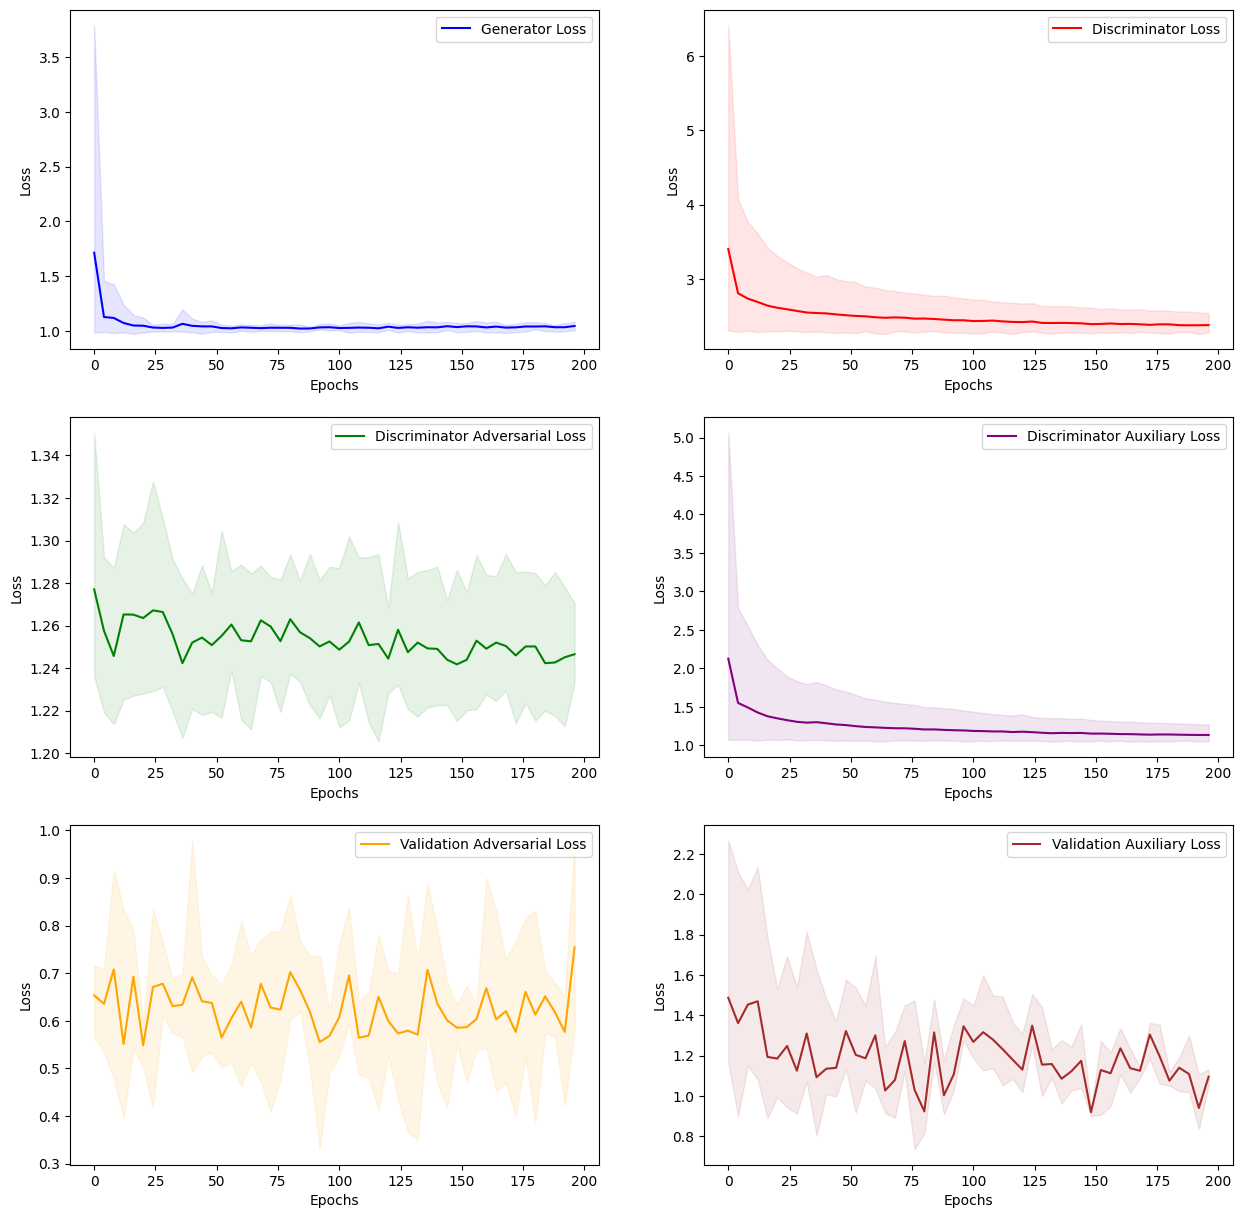

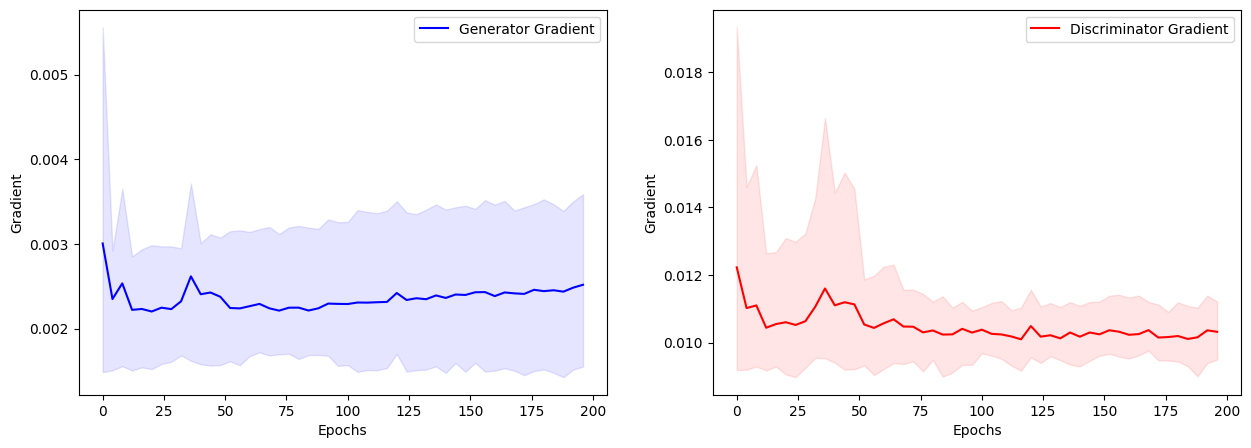

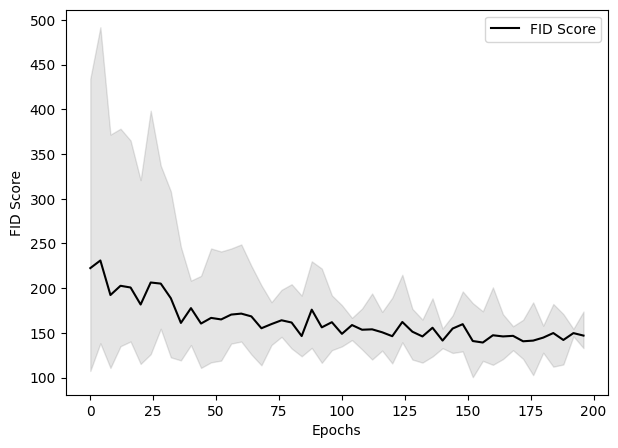

In [ ]:
num_splits = 4

# Function to split data
def split_data(data, num_intervals):
    split_size = len(data) // num_intervals
    return [data[i*split_size:(i+1)*split_size] for i in range(num_intervals)]

# Splitting the data
G_loss_splits = split_data(G_loss, num_splits)
D_loss_splits = split_data(D_loss, num_splits)
D_adv_loss_splits = split_data(D_adv_loss, num_splits)
D_aux_loss_splits = split_data(D_aux_loss, num_splits)
D_val_adv_loss_splits = split_data(D_val_adv_loss, num_splits)
D_val_aux_loss_splits = split_data(D_val_aux_loss, num_splits)
G_grad_splits = split_data(G_grad, num_splits)
D_grad_splits = split_data(D_grad, num_splits)
FID_splits = split_data(FID, num_splits)

# Plotting function with shaded area
def plot_with_shades(ax, data, label, color):
    #epochs = range(len(data[0])) * num_splits
    epochs = [epoch * num_splits for epoch in range(num_epochs // num_splits)]
    means = np.mean(data, axis=0)
    minima = np.min(data, axis=0)
    maxima = np.max(data, axis=0)

    ax.plot(epochs, means, label=label, color=color)
    ax.fill_between(epochs, minima, maxima, color=color, alpha=0.1)

# Create a figure and a set of subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Plotting
plot_with_shades(axs[0, 0], G_loss_splits, 'Generator Loss', 'blue')
plot_with_shades(axs[0, 1], D_loss_splits, 'Discriminator Loss', 'red')
plot_with_shades(axs[1, 0], D_adv_loss_splits, 'Discriminator Adversarial Loss', 'green')
plot_with_shades(axs[1, 1], D_aux_loss_splits, 'Discriminator Auxiliary Loss', 'purple')
plot_with_shades(axs[2, 0], D_val_adv_loss_splits, 'Validation Adversarial Loss', 'orange')
plot_with_shades(axs[2, 1], D_val_aux_loss_splits, 'Validation Auxiliary Loss', 'brown')

fig, axg = plt.subplots(1, 2, figsize=(15, 5))
plot_with_shades(axg[0], G_grad_splits, 'Generator Gradient', 'blue')
plot_with_shades(axg[1], D_grad_splits, 'Discriminator Gradient', 'red')

# Plotting FID on its own figure because it often has a different scale
fig, ax_fid = plt.subplots(figsize=(7, 5))
plot_with_shades(ax_fid, FID_splits, 'FID Score', 'black')

# Adding labels and legends
for ax in axs.flat:
    ax.set(xlabel='Epochs', ylabel='Loss')
    ax.legend(loc='upper right')

for ax in axg.flat:
    ax.set(xlabel='Epochs', ylabel='Gradient')
    ax.legend(loc='upper right')

ax_fid.set(xlabel='Epochs', ylabel='FID Score')
ax_fid.legend(loc='upper right')

plt.show()

# Print sample images

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def generate_class_samples(generator, num_classes, num_samples, z_dim, device):
    with torch.no_grad():
        fake_images = []
        for i in range(num_classes):
            # Generate latent vectors and class labels for the current class
            noise = torch.randn(num_samples, z_dim, device=device)
            labels = torch.full((num_samples,), i, dtype=torch.long, device=device)

            # Generate images
            images = generator(noise, labels).detach().cpu()
            fake_images.append(images)

        return fake_images

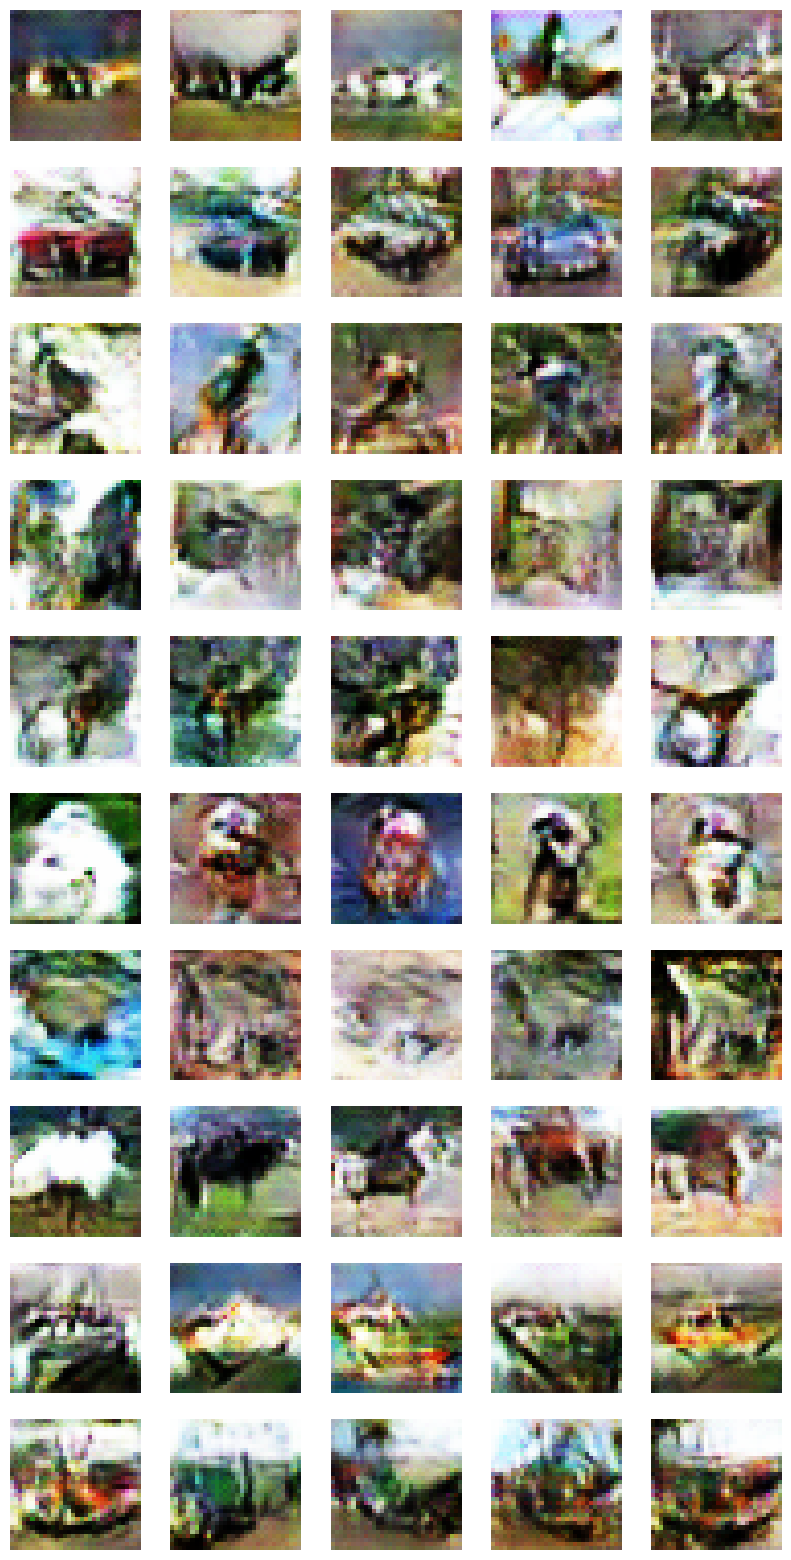

In [18]:
# Assuming generator is already moved to the correct device with generator.to(device)
# Generate and display the images
num_samples = 5  # The number of samples you want to generate per class
fake_images_per_class = generate_class_samples(generator, num_classes, num_samples, z_dim, device)

# Display the generated images
fig, axs = plt.subplots(num_classes, num_samples, figsize=(num_samples * 2, num_classes * 2))
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for class_idx, class_images in enumerate(fake_images_per_class):
    for sample_idx in range(num_samples):
        img = class_images[sample_idx]
        img = (img + 1) / 2  # Rescale images to [0, 1]
        axs[class_idx, sample_idx].imshow(np.transpose(img, (1, 2, 0)))
        axs[class_idx, sample_idx].axis('off')

    axs[class_idx, 0].set_ylabel(class_names[class_idx])

plt.show()

# Latent space interpolations

In [12]:
def interpolate_point(p1, p2, num_steps):
    # Interpolates linearly between two points in the latent space.
    alpha_values = np.linspace(0, 1, num_steps)
    return (1 - alpha_values[:, None]) * p1 + alpha_values[:, None] * p2

def generate_images(generator, latent_dim, num_interpolations, device):
    """ Generates images by interpolating between random points in the latent space. """
    # Randomly generate start and end points for the interpolation
    interpolation_sample_size = 10
    z_start = torch.normal(0, 1.5, (interpolation_sample_size, z_dim)).to(device)
    z_end = torch.normal(0, 1.5, (interpolation_sample_size, z_dim)).to(device)
    gen_labels = torch.randint(0, num_classes, (interpolation_sample_size,), device=device).long()

    interpolated_images = []

    # Perform interpolation between z_start and z_end
    for i in range(interpolation_sample_size):
        z_interpolated = interpolate_point(z_start[i].cpu().numpy(), z_end[i].cpu().numpy(), num_interpolations)
        z_interpolated = torch.tensor(z_interpolated, dtype=torch.float32).to(device)

        # Generate images from interpolated latent vectors
        with torch.no_grad():
            images = generator(z_interpolated, gen_labels).detach().cpu()
            interpolated_images.append(images)

    return interpolated_images


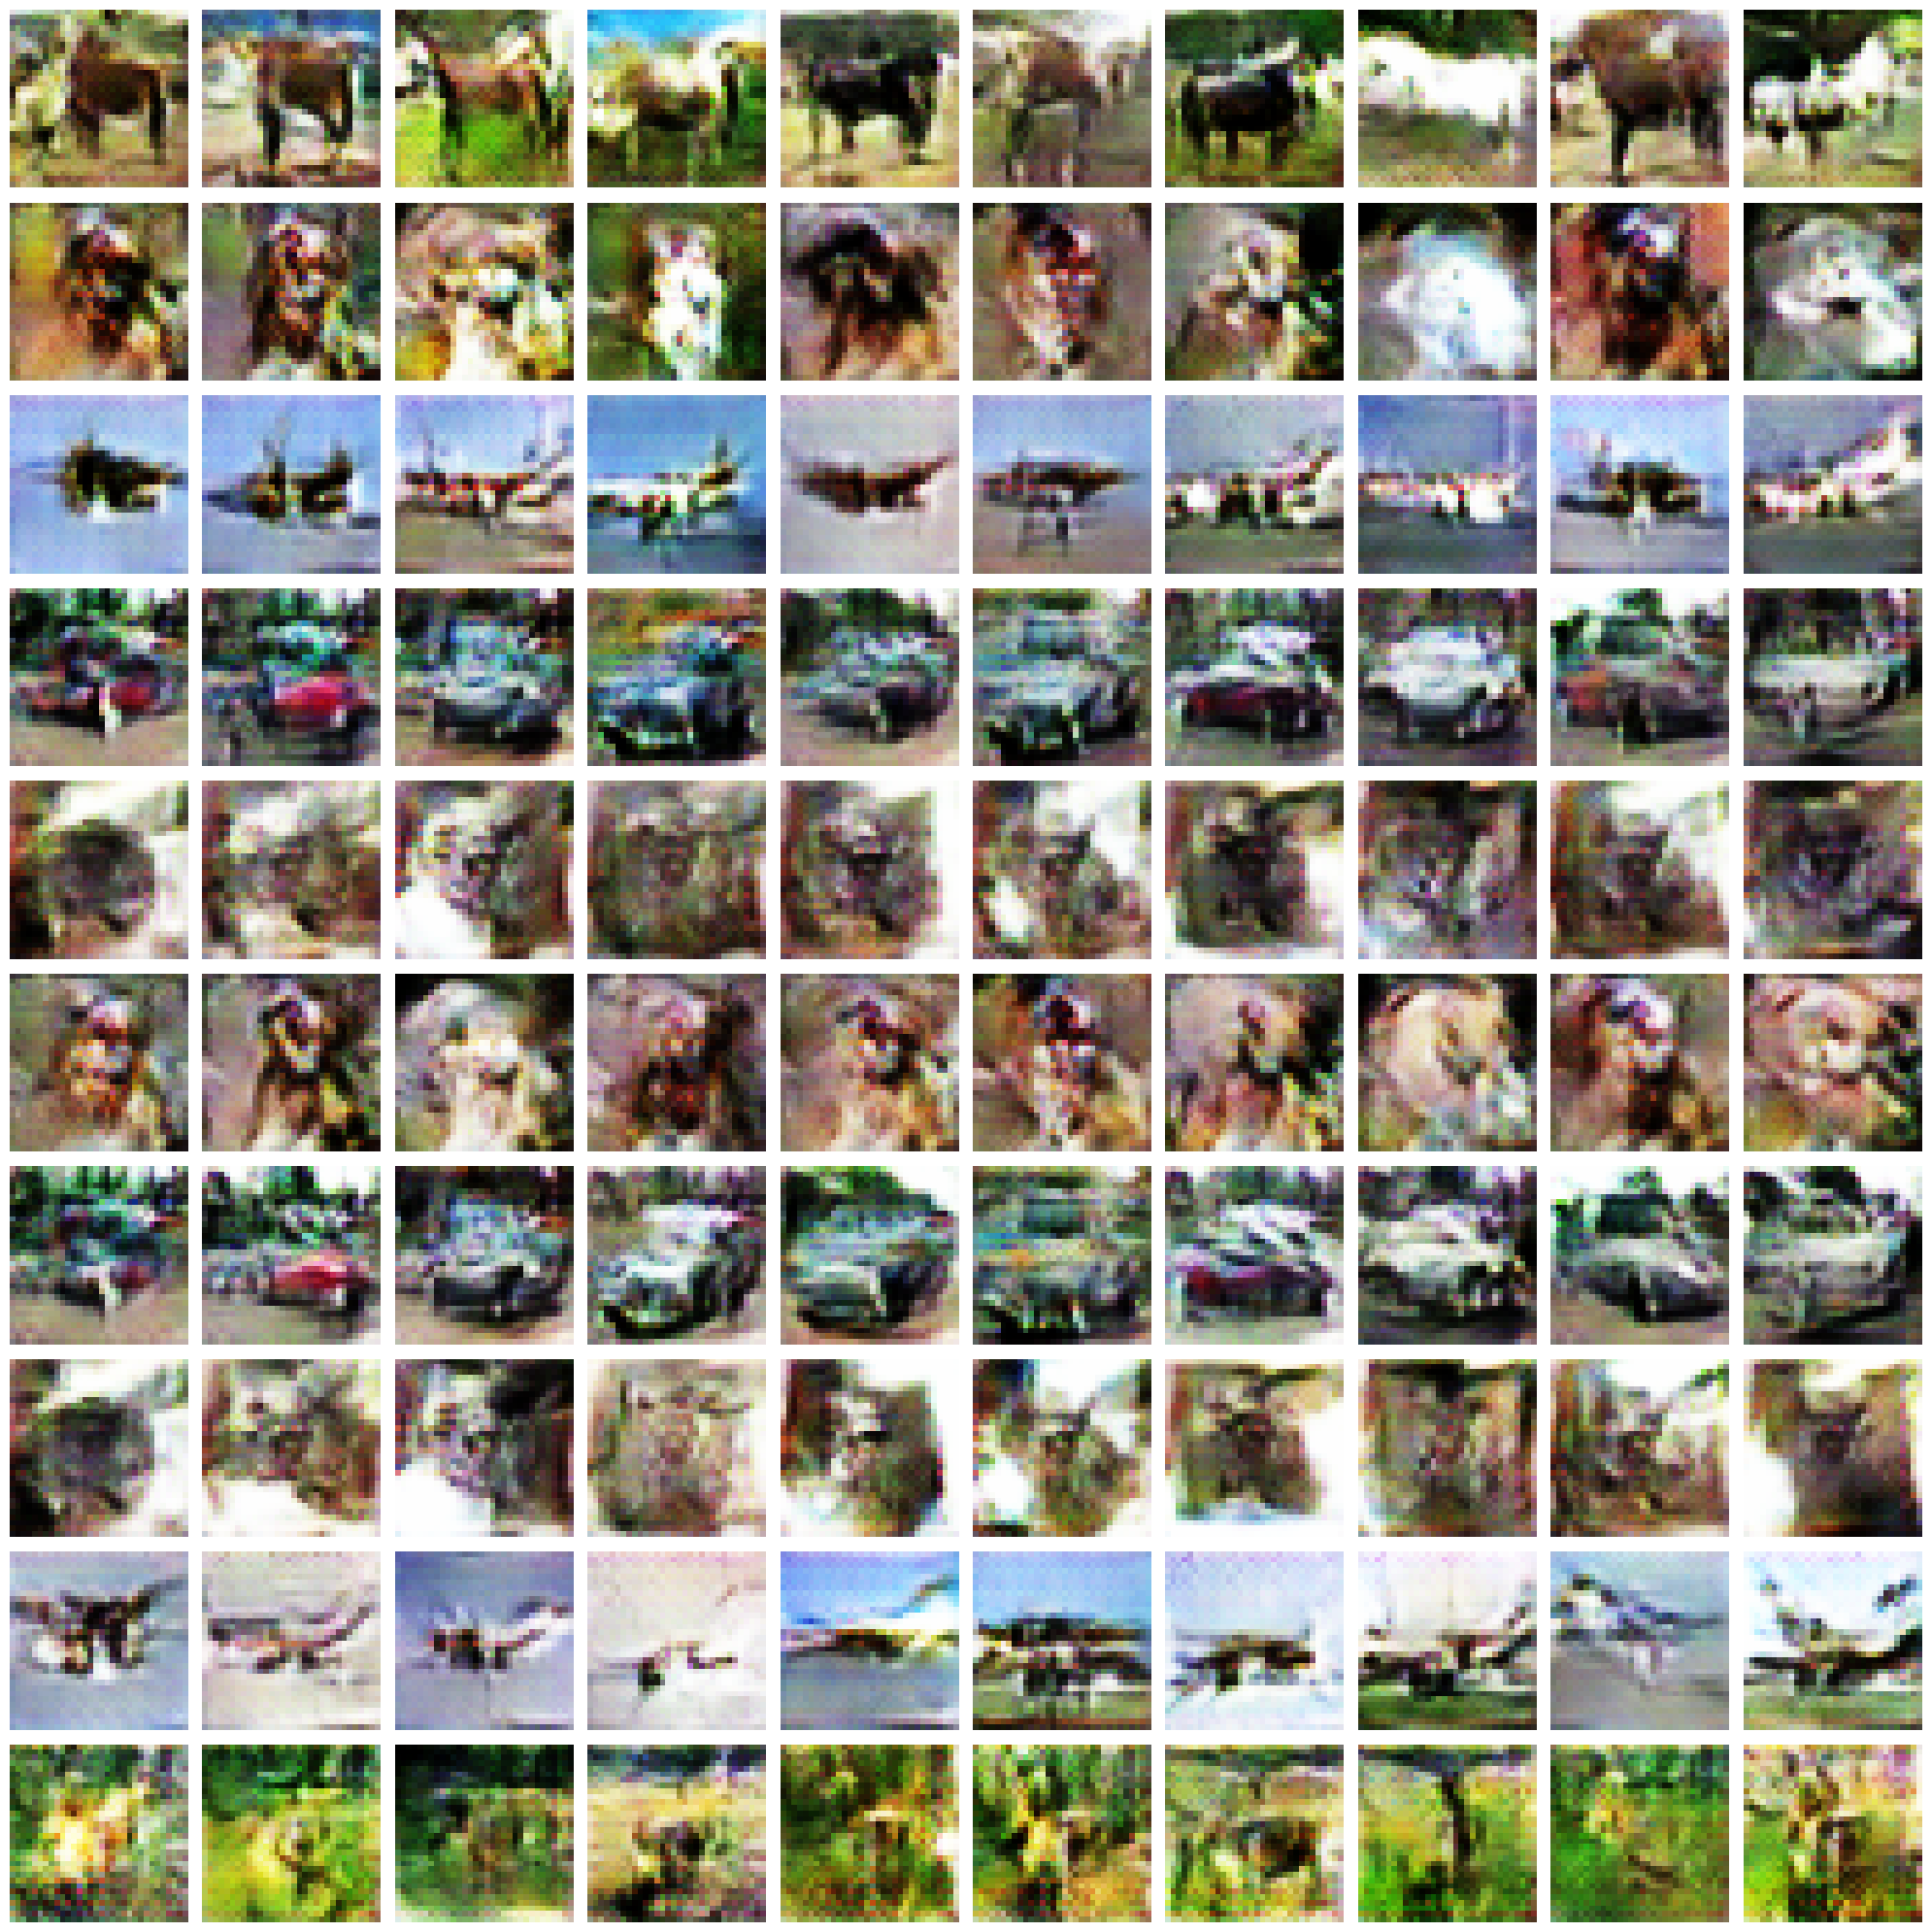

"\nfor img_set in interpolated_images:\n    plt.figure(figsize=(15, 2))\n    for i, img in enumerate(img_set):\n        img = (img + 1) / 2  # Rescale images to [0, 1]\n        plt.subplot(1, len(img_set), i + 1)\n        #plt.subplot(1, 10, i + 1)\n        plt.imshow(img.cpu().numpy().transpose(1, 2, 0))  # Adjust this if images are grayscale\n        plt.axis('off')\n    plt.show()\n"

In [15]:
# Call the function to generate interpolated images
interpolated_images = generate_images(generator, z_dim, num_interpolations=10, device=device)

# Visualization of the interpolated images
num_columns = len(interpolated_images)
num_rows = len(interpolated_images[0])
plt.figure(figsize=(num_columns * 2, num_rows * 2))
for col_index, img_set in enumerate(interpolated_images):
    for row_index, img in enumerate(img_set):
        # Calculate subplot index: 1-based index, traversing rows first
        subplot_index = row_index * num_columns + col_index + 1
        plt.subplot(num_rows, num_columns, subplot_index)
        img = (img + 1) / 2  # Rescale images to [0, 1]
        plt.imshow(img.cpu().numpy().transpose(1, 2, 0))
        plt.axis('off')  # Hide axes

# Show the plot
plt.tight_layout()  # Adjust subplot params for neatness
plt.show()
'''
for img_set in interpolated_images:
    plt.figure(figsize=(15, 2))
    for i, img in enumerate(img_set):
        img = (img + 1) / 2  # Rescale images to [0, 1]
        plt.subplot(1, len(img_set), i + 1)
        #plt.subplot(1, 10, i + 1)
        plt.imshow(img.cpu().numpy().transpose(1, 2, 0))  # Adjust this if images are grayscale
        plt.axis('off')
    plt.show()
'''